This code is submitted by Vansh Maheshwari and Parth Parashar
Group no- 8

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

!ls /kaggle/input/

# Any results you write to the current directory are saved as output.

e121-bert-question     google-quest-challenge
e125-bert-answer       guchio-transformers
e126-roberta-question  huggingface-model-configs
e127-roberta-answer    sub-e078-e083-bert2-roberta1-xlnet1
e128-xlnet-question    sub-e121-e129-bert1-roberta2-xlnet1
e129-xlnet-answer


In [ ]:
!ls /kaggle/input/e127-roberta-answer
!ls /kaggle/input/huggingface-model-configs
!ls /kaggle/input/sub-e078-e083-bert2-roberta1-xlnet1

added_tokens.json  optRs.pkl		    state_dicts		   vocab.json
merges.txt	   special_tokens_map.json  tokenizer_config.json
bert-model-uncased-config.pkl  roberta-model-base-config.pkl
gpt2-model-config.pkl	       xlnet-model-base-cased-config.pkl
optRs.pkl  optRs_initial.pkl


In [ ]:
test_df = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')
train_df = pd.read_csv('/kaggle/input/google-quest-challenge/train.csv')

## pre-settings

In [ ]:
import os

def OSprint(string):
    os.system(f'echo \"{string}\"')
    print(string)

In [ ]:
!ls /kaggle/input/

e121-bert-question     google-quest-challenge
e125-bert-answer       guchio-transformers
e126-roberta-question  huggingface-model-configs
e127-roberta-answer    sub-e078-e083-bert2-roberta1-xlnet1
e128-xlnet-question    sub-e121-e129-bert1-roberta2-xlnet1
e129-xlnet-answer


In [ ]:
NUM_FOLDS = 5
DEVICE = 'cuda'
#DEVICE = 'cpu'
BATCH_SIZE = 8

BERT_BASE_MODEL_PATH = '/kaggle/input/huggingface-model-configs/bert-model-uncased-config.pkl'
ROBERTA_BASE_MODEL_PATH = '/kaggle/input/huggingface-model-configs/roberta-model-base-config.pkl'
XLNET_BASE_MODEL_PATH = '/kaggle/input/huggingface-model-configs/xlnet-model-base-cased-config.pkl'
BERT_Q_BASE_PATH = '/kaggle/input/e121-bert-question/'
BERT_A_BASE_PATH = '/kaggle/input/e125-bert-answer/'
ROBERTA_Q_BASE_PATH = '/kaggle/input/e126-roberta-question/'
ROBERTA_A_BASE_PATH = '/kaggle/input/e127-roberta-answer/'
XLNET_Q_BASE_PATH = '/kaggle/input/e128-xlnet-question/'
XLNET_A_BASE_PATH = '/kaggle/input/e129-xlnet-answer/'

In [ ]:
Q_LABEL_COL = [
    'question_asker_intent_understanding',
    'question_body_critical',
    'question_conversational',
    'question_expect_short_answer',
    'question_fact_seeking',
    'question_has_commonly_accepted_answer',
    'question_interestingness_others',
    'question_interestingness_self',
    'question_multi_intent',
    'question_not_really_a_question',
    'question_opinion_seeking',
    'question_type_choice',
    'question_type_compare',
    'question_type_consequence',
    'question_type_definition',
    'question_type_entity',
    'question_type_instructions',
    'question_type_procedure',
    'question_type_reason_explanation',
    'question_type_spelling',
    'question_well_written',
]

A_LABEL_COL = [
    'answer_helpful',
    'answer_level_of_information',
    'answer_plausible',
    'answer_relevance',
    'answer_satisfaction',
    'answer_type_instructions',
    'answer_type_procedure',
    'answer_type_reason_explanation',
    'answer_well_written'
]

In [ ]:
!pip install /kaggle/input/sacremoses-master/sacremoses > /dev/null
#!pip install /kaggle/input/transformers/transformers-master #> /dev/null
!pip install --no-deps /kaggle/input/guchio-transformers/*.whl #> /dev/null

ERROR: Invalid requirement: '/kaggle/input/sacremoses-master/sacremoses'
Hint: It looks like a path. File '/kaggle/input/sacremoses-master/sacremoses' does not exist.
Processing /kaggle/input/guchio-transformers/boto3-1.10.46-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/botocore-1.13.46-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/numpy-1.18.0-cp36-cp36m-manylinux1_x86_64.whl
Processing /kaggle/input/guchio-transformers/regex-2019.12.20-cp36-cp36m-manylinux2010_x86_64.whl
Processing /kaggle/input/guchio-transformers/s3transfer-0.2.1-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/six-1.13.0-py2.py3-none-any.whl
  Found existing installation: boto3 1.11.9
    Uninstalling boto3-1.11.9:
      Successfully uninstalled boto3-1.11.9
  Found existing installation: botocore 1.14.9
    Uninstalling botocore-1.14.9:
      Successfully uninstalled botocore-1.14.9
  Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer, XLNetModel, XLNetTokenizer
import random
from math import ceil, floor
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import pickle
import gc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
train_data=train_df
test_data=test_df
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import string
eng_stopwords = stopwords.words('english')
import gc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [ ]:
OSprint('start training!')

start training!


EDA

In [ ]:
print('Size of train_data', train_data.shape)
print('Size of test_data', test_data.shape)

Size of train_data (6079, 41)
Size of test_data (476, 11)


In [ ]:
targets = list(train_data.columns[11:])
targets

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [ ]:
train_data[targets].describe()

question_asker_intent_understanding  question_body_critical  \
count                          6079.000000             6079.000000   
mean                              0.892663                0.595301   
std                               0.132047                0.219470   
min                               0.333333                0.333333   
25%                               0.777778                0.444444   
50%                               0.888889                0.555556   
75%                               1.000000                0.777778   
max                               1.000000                1.000000   

       question_conversational  question_expect_short_answer  \
count              6079.000000                   6079.000000   
mean                  0.057301                      0.698525   
std                   0.182196                      0.350938   
min                   0.000000                      0.000000   
25%                   0.000000                      0.500000   
50%                   0.000000                      0.666667   
75%                   0.000000                      1.000000   
max                   1.000000                      1.000000   

       question_fact_seeking  question_has_commonly_accepted_answer  \
count            6079.000000                            6079.000000   
mean                0.772633                               0.793689   
std                 0.303023                               0.336622   
min                 0.000000                               0.000000   
25%                 0.666667                               0.666667   
50%                 1.000000                               1.000000   
75%                 1.000000                               1.000000   
max                 1.000000                               1.000000   

       question_interestingness_others  question_interestingness_self  \
count                      6079.000000                    6079.000000   
mean                          0.587478                       0.507275   
std                           0.135900                       0.185987   
min                           0.333333                       0.333333   
25%                           0.444444                       0.333333   
50%                           0.555556                       0.444444   
75%                           0.666667                       0.666667   
max                           1.000000                       1.000000   

       question_multi_intent  question_not_really_a_question  ...  \
count            6079.000000                     6079.000000  ...   
mean                0.238745                        0.004469  ...   
std                 0.335057                        0.045782  ...   
min                 0.000000                        0.000000  ...   
25%                 0.000000                        0.000000  ...   
50%                 0.000000                        0.000000  ...   
75%                 0.333333                        0.000000  ...   
max                 1.000000                        1.000000  ...   

       question_well_written  answer_helpful  answer_level_of_information  \
count            6079.000000     6079.000000                  6079.000000   
mean                0.799931        0.925408                     0.654823   
std                 0.178420        0.114836                     0.107666   
min                 0.333333        0.333333                     0.333333   
25%                 0.666667        0.888889                     0.666667   
50%                 0.833333        1.000000                     0.666667   
75%                 1.000000        1.000000                     0.666667   
max                 1.000000        1.000000                     1.000000   

       answer_plausible  answer_relevance  answer_satisfaction  \
count       6079.000000       6079.000000          6079.000000   
mean           0.960054          0.968626            

In [ ]:
# checking missing data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

Total  Percent
answer_well_written                        0      0.0
question_multi_intent                      0      0.0
question_interestingness_others            0      0.0
question_has_commonly_accepted_answer      0      0.0
question_fact_seeking                      0      0.0

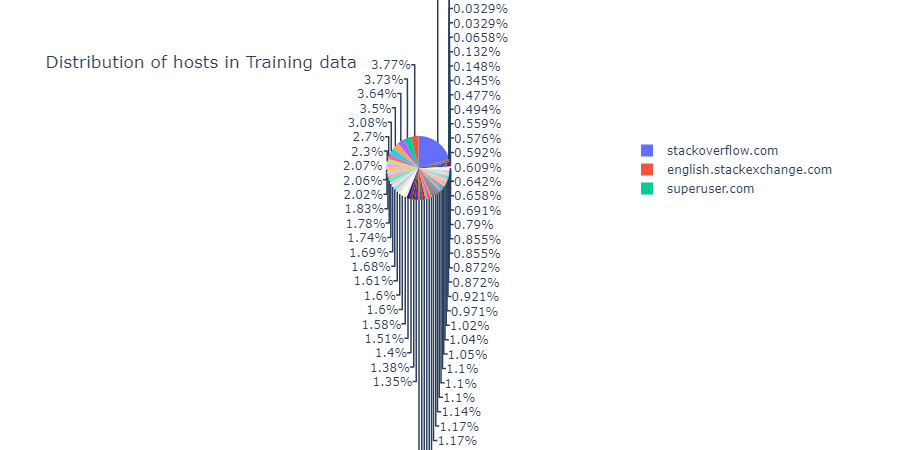

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

temp = train_data["host"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

trace = go.Pie(labels=df['labels'], values=df['values'])
layout = go.Layout(title='Distribution of hosts in Training data')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


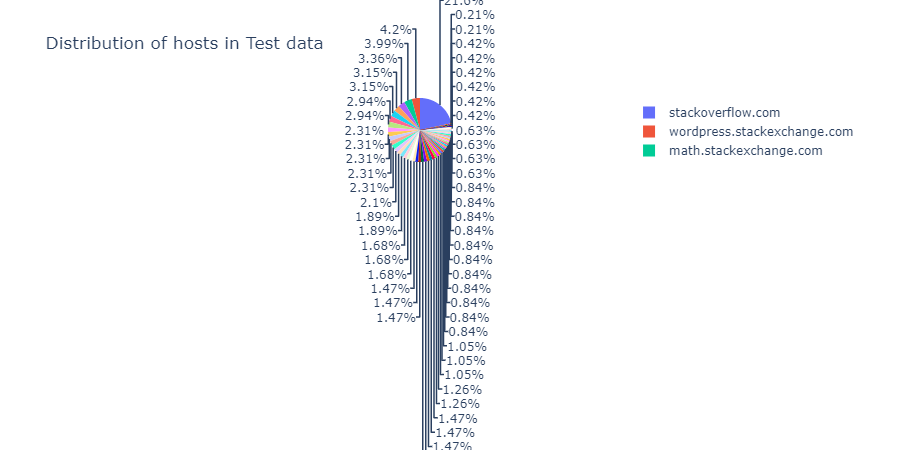

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

temp = test_data["host"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

trace = go.Pie(labels=df['labels'], values=df['values'])
layout = go.Layout(title='Distribution of hosts in Test data')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


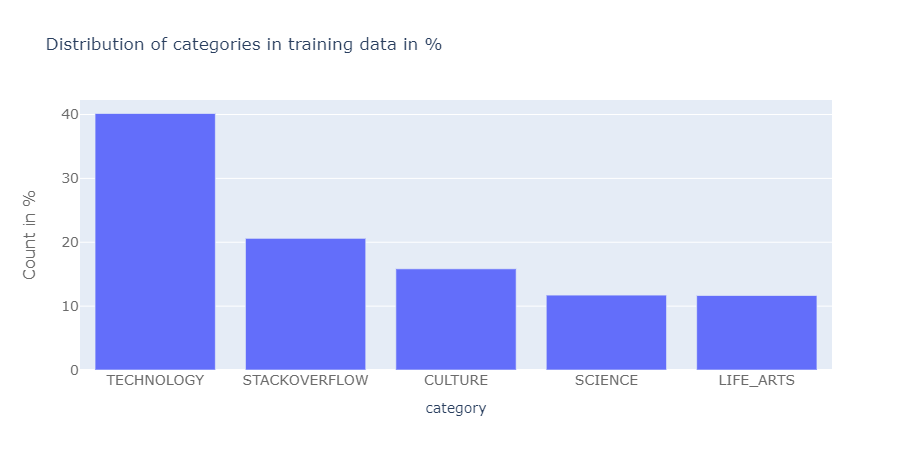

In [ ]:
temp = train_data["category"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of categories in training data in % ",
    xaxis=dict(
        title='category',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
     yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='test')

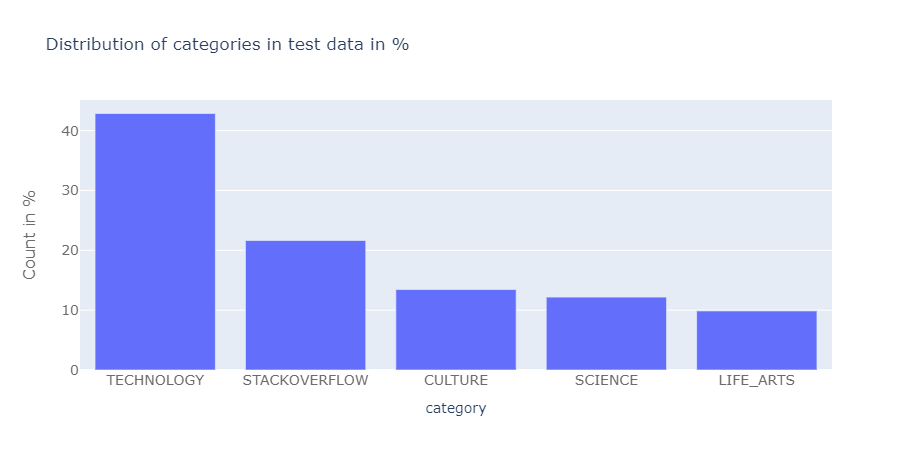

In [ ]:
temp = test_data["category"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of categories in test data in % ",
    xaxis=dict(
        title='category',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='test')

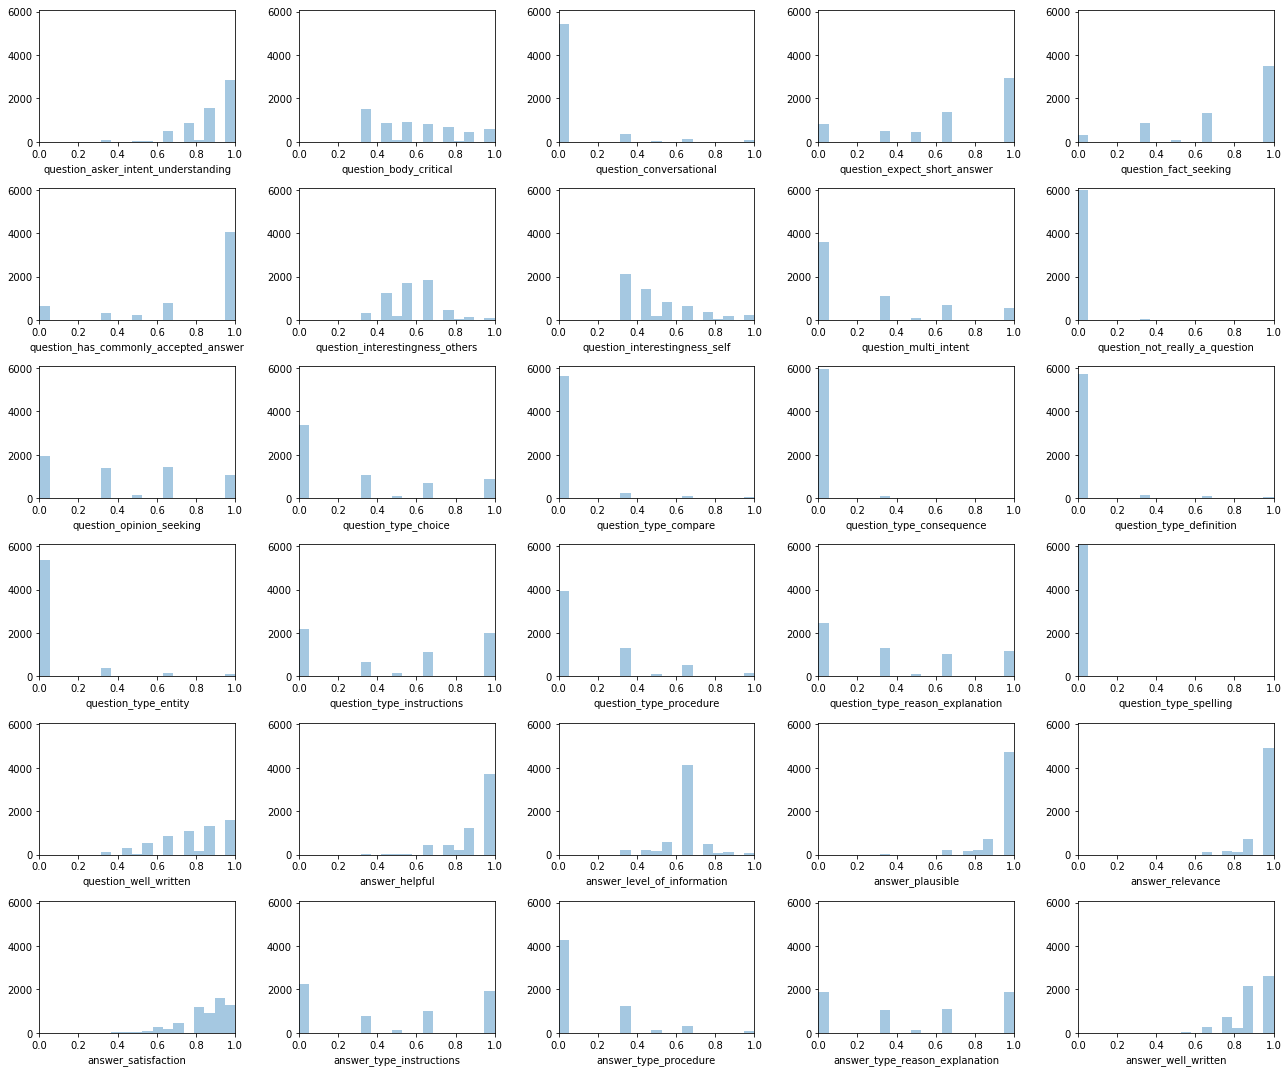

In [ ]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(targets):
    ax = axes[i]
    sns.distplot(train_data[col], label=col, kde=False, bins=bins, ax=ax)
    # ax.set_title(col)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])
plt.tight_layout()
plt.show()
plt.close()

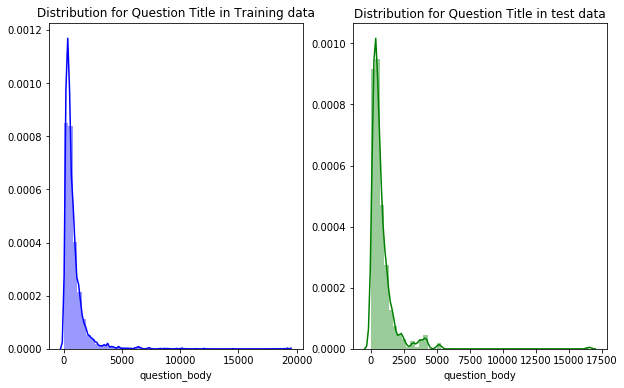

Coordinates of the highest point for Training Data:
x-coordinate (Question Title Length): 357.58626238205636
y-coordinate (Density Value): 0.001168532037572779

Coordinates of the highest point for Test Data:
x-coordinate (Question Title Length): 388.67254140833546
y-coordinate (Density Value): 0.0010164307014363353


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_question_title and test_question_title are already defined

# Plotting the distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(train_question_title, ax=ax1, color='blue')
sns.distplot(test_question_title, ax=ax2, color='green')
ax2.set_title('Distribution for Question Title in test data')
ax1.set_title('Distribution for Question Title in Training data')

# Finding the peak coordinates for training data
line1 = ax1.lines[0]  # KDE line for training data
x_train = line1.get_xdata()
y_train = line1.get_ydata()
max_index_train = np.argmax(y_train)
peak_x_train = x_train[max_index_train]
peak_y_train = y_train[max_index_train]

# Finding the peak coordinates for test data
line2 = ax2.lines[0]  # KDE line for test data
x_test = line2.get_xdata()
y_test = line2.get_ydata()
max_index_test = np.argmax(y_test)
peak_x_test = x_test[max_index_test]
peak_y_test = y_test[max_index_test]

# Showing the plots
plt.show()

# Printing the coordinates
print("Coordinates of the highest point for Training Data:")
print("x-coordinate (Question Title Length):", peak_x_train)
print("y-coordinate (Density Value):", peak_y_train)

print("\nCoordinates of the highest point for Test Data:")
print("x-coordinate (Question Title Length):", peak_x_test)
print("y-coordinate (Density Value):", peak_y_test)


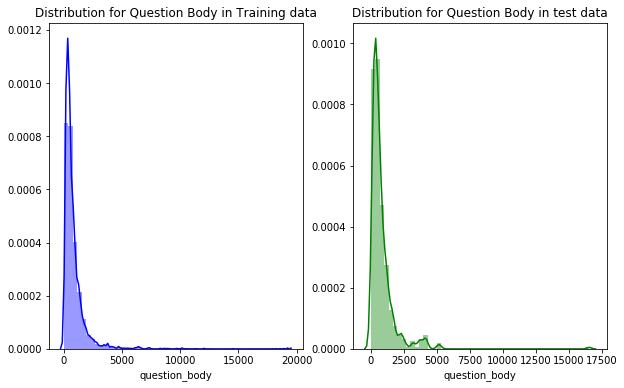

Coordinates of the highest point for Training Data:
x-coordinate (Question body Length): 357.58626238205636
y-coordinate (Density Value): 0.001168532037572779

Coordinates of the highest point for Test Data:
x-coordinate (Question body Length): 388.67254140833546
y-coordinate (Density Value): 0.0010164307014363353


In [ ]:
train_question_title=train_data['question_body'].str.len()
test_question_title=test_data['question_body'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Question Body in test data')
ax1.set_title('Distribution for Question Body in Training data')
# Finding the peak coordinates for training data
line1 = ax1.lines[0]  # KDE line for training data
x_train = line1.get_xdata()
y_train = line1.get_ydata()
max_index_train = np.argmax(y_train)
peak_x_train = x_train[max_index_train]
peak_y_train = y_train[max_index_train]

# Finding the peak coordinates for test data
line2 = ax2.lines[0]  # KDE line for test data
x_test = line2.get_xdata()
y_test = line2.get_ydata()
max_index_test = np.argmax(y_test)
peak_x_test = x_test[max_index_test]
peak_y_test = y_test[max_index_test]

# Showing the plots
plt.show()

# Printing the coordinates
print("Coordinates of the highest point for Training Data:")
print("x-coordinate (Question body Length):", peak_x_train)
print("y-coordinate (Density Value):", peak_y_train)

print("\nCoordinates of the highest point for Test Data:")
print("x-coordinate (Question body Length):", peak_x_test)
print("y-coordinate (Density Value):", peak_y_test)

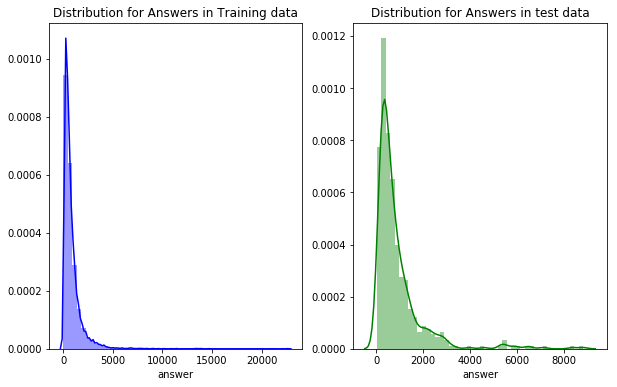

Coordinates of the highest point for Training Data:
x-coordinate (Answer Length): 272.9539495488209
y-coordinate (Density Value): 0.0010708281546514629

Coordinates of the highest point for Test Data:
x-coordinate (Answer Length): 366.17569252476505
y-coordinate (Density Value): 0.0009562462837731688


In [ ]:
train_question_title=train_data['answer'].str.len()
test_question_title=test_data['answer'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Answers in test data')
ax1.set_title('Distribution for Answers in Training data')
# Finding the peak coordinates for training data
line1 = ax1.lines[0]  # KDE line for training data
x_train = line1.get_xdata()
y_train = line1.get_ydata()
max_index_train = np.argmax(y_train)
peak_x_train = x_train[max_index_train]
peak_y_train = y_train[max_index_train]

# Finding the peak coordinates for test data
line2 = ax2.lines[0]  # KDE line for test data
x_test = line2.get_xdata()
y_test = line2.get_ydata()
max_index_test = np.argmax(y_test)
peak_x_test = x_test[max_index_test]
peak_y_test = y_test[max_index_test]

# Showing the plots
plt.show()

# Printing the coordinates
print("Coordinates of the highest point for Training Data:")
print("x-coordinate (Answer Length):", peak_x_train)
print("y-coordinate (Density Value):", peak_y_train)

print("\nCoordinates of the highest point for Test Data:")
print("x-coordinate (Answer Length):", peak_x_test)
print("y-coordinate (Density Value):", peak_y_test)

In [ ]:
from wordcloud import WordCloud


def plot_wordcloud(text, ax, title=None):
    wordcloud = WordCloud(max_font_size=None, background_color='white',
                          width=1200, height=1000).generate(text_cat)
    ax.imshow(wordcloud)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")

Training data Word Cloud


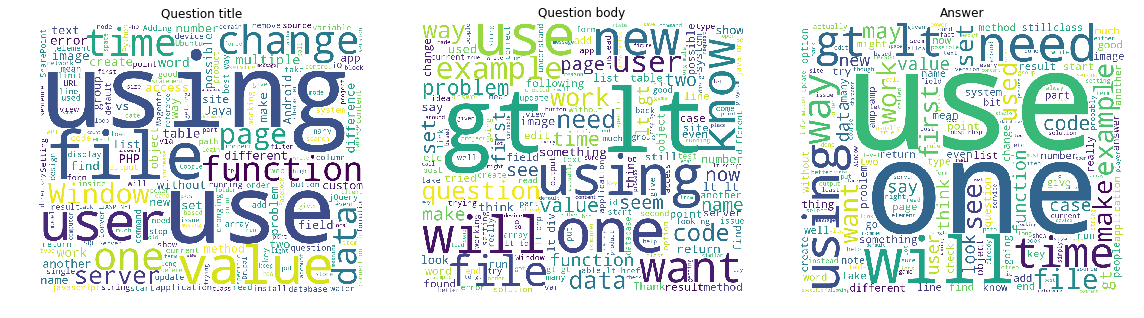

In [ ]:
print('Training data Word Cloud')

fig, axes = plt.subplots(1, 3, figsize=(16, 18))

text_cat = ' '.join(train_data['question_title'].values)
plot_wordcloud(text_cat, axes[0], 'Question title')

text_cat = ' '.join(train_data['question_body'].values)
plot_wordcloud(text_cat, axes[1], 'Question body')

text_cat = ' '.join(train_data['answer'].values)
plot_wordcloud(text_cat, axes[2], 'Answer')

plt.tight_layout()
fig.show()

Test data Word Cloud


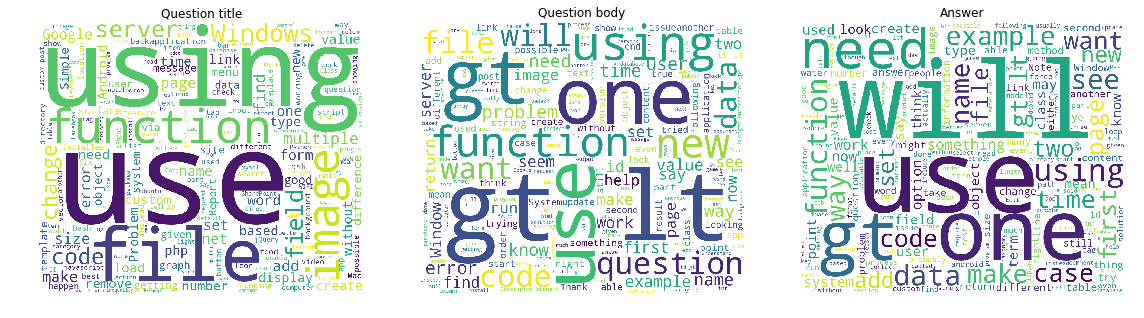

In [ ]:
print('Test data Word Cloud')

fig, axes = plt.subplots(1, 3, figsize=(16, 18))

text_cat = ' '.join(test_data['question_title'].values)
plot_wordcloud(text_cat, axes[0], 'Question title')

text_cat = ' '.join(test_data['question_body'].values)
plot_wordcloud(text_cat, axes[1], 'Question body')

text_cat = ' '.join(test_data['answer'].values)
plot_wordcloud(text_cat, axes[2], 'Answer')

plt.tight_layout()

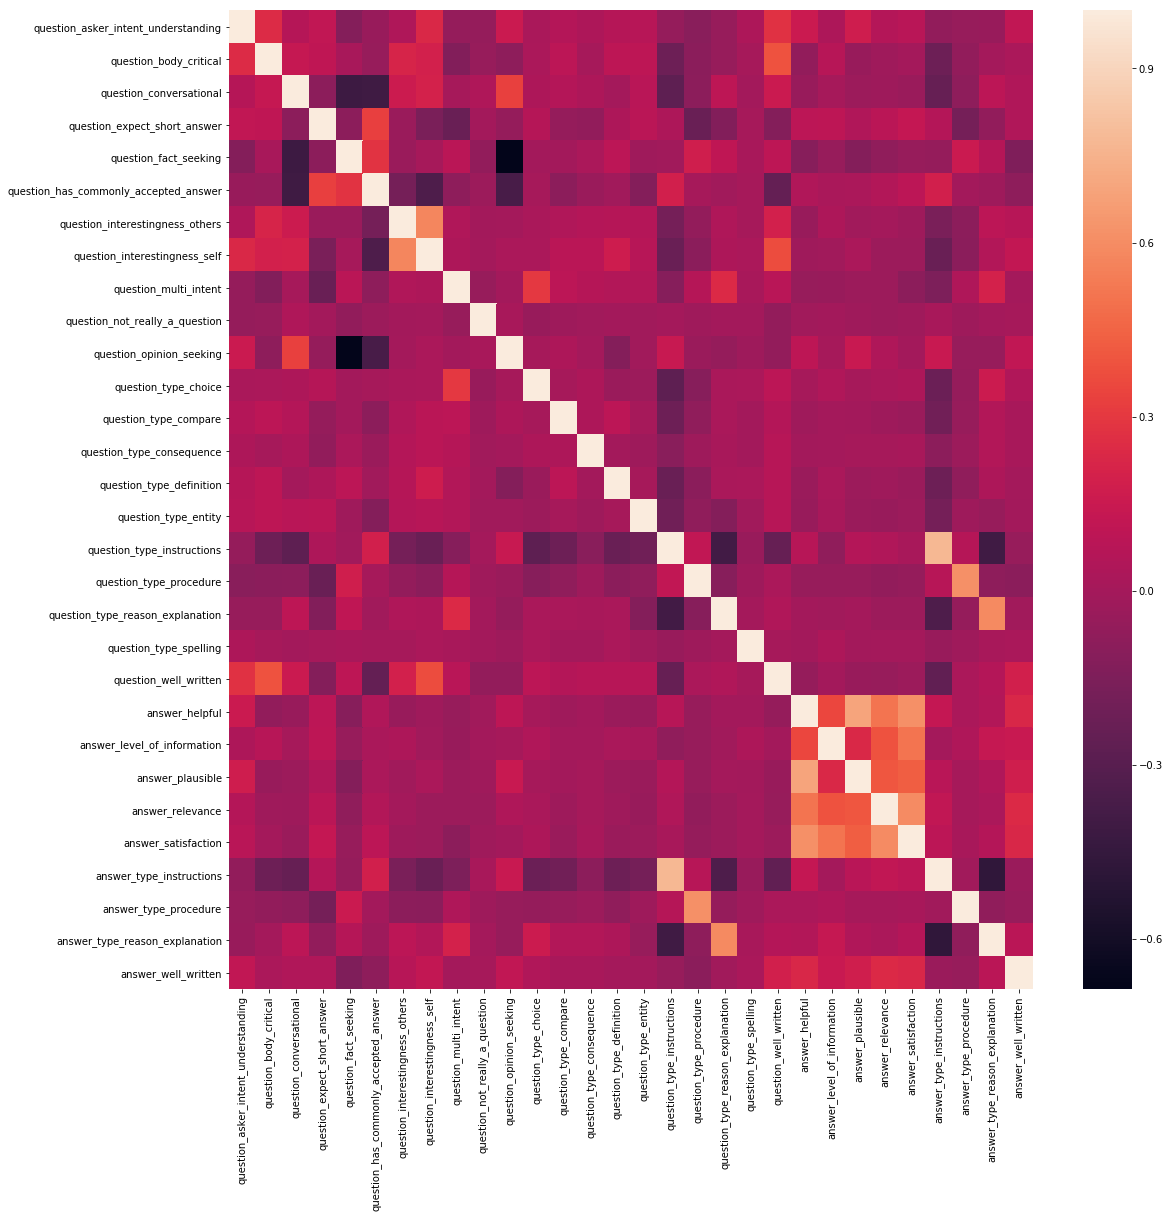

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_data[targets].corr(), ax=ax)

In [ ]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data
# Lowercase all text
def lowercase_text(data):
    return data.lower()

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply stemming
def apply_stemming(text):
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply lemmatization
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [ ]:
 # Apply preprocessing steps
train_data['question_body'] = train_data['question_body'].apply(lambda z: remove_html(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: remove_url(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: remove_emoji(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: remove_punctuations(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: lowercase_text(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: remove_stopwords(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: apply_stemming(z))
train_data['question_body'] = train_data['question_body'].apply(lambda z: apply_lemmatization(z))

In [ ]:
train_data['answer'] = train_data['answer'].apply(lambda z: remove_punctuations(z))
train_data['answer'] = train_data['answer'].apply(lambda z: remove_html(z))
train_data['answer'] = train_data['answer'].apply(lambda z: remove_url(z))
train_data['answer'] = train_data['answer'].apply(lambda z: remove_emoji(z))
train_data['answer'] = train_data['answer'].apply(lambda z: lowercase_text(z))
train_data['answer'] = train_data['answer'].apply(lambda z: remove_stopwords(z))
train_data['answer'] = train_data['answer'].apply(lambda z: apply_stemming(z))
train_data['answer'] = train_data['answer'].apply(lambda z: apply_lemmatization(z))

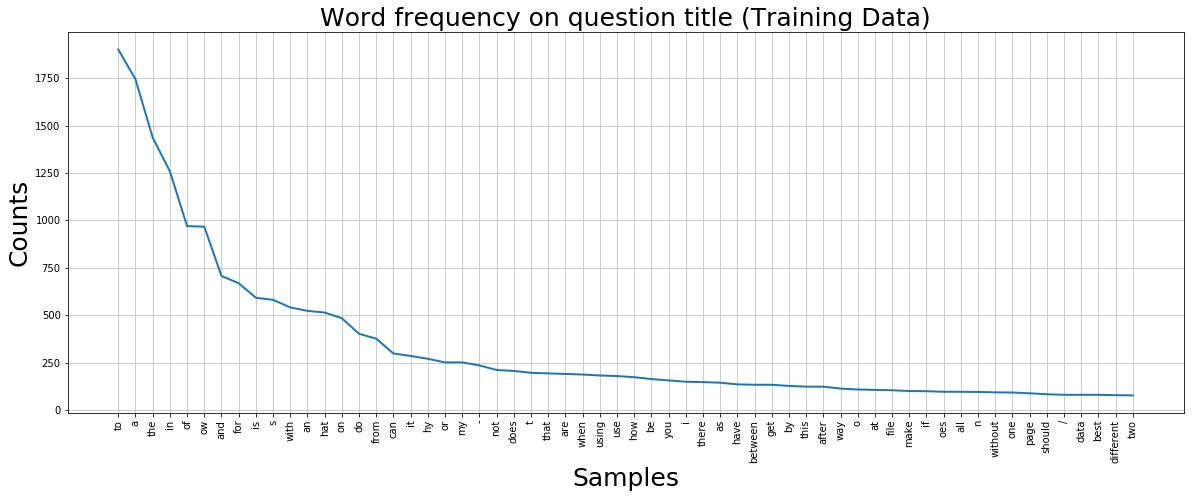

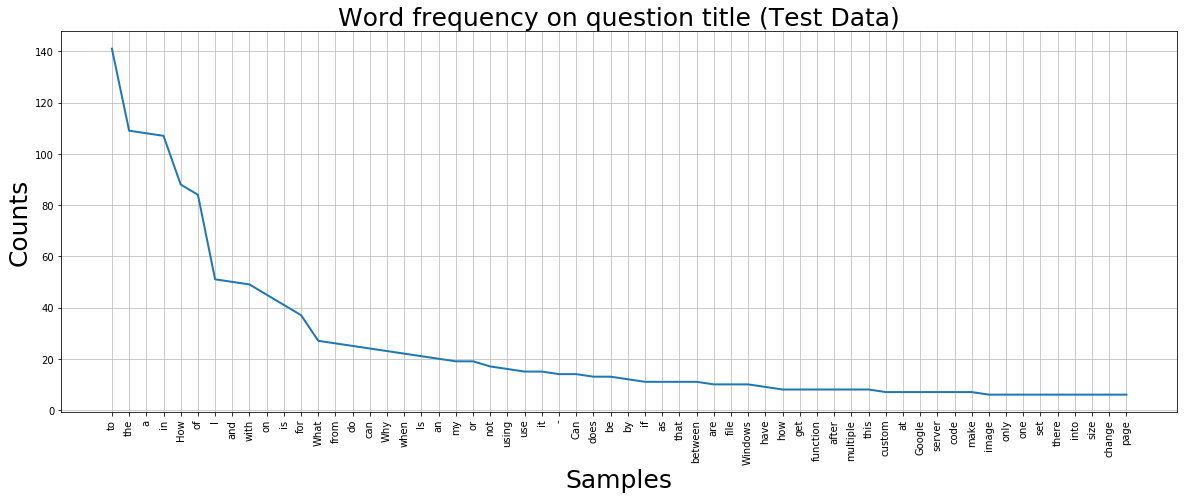

In [ ]:
# training data
freq_dist = FreqDist([word for text in train_data['question_title'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

# test data
freq_dist = FreqDist([word for text in test_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

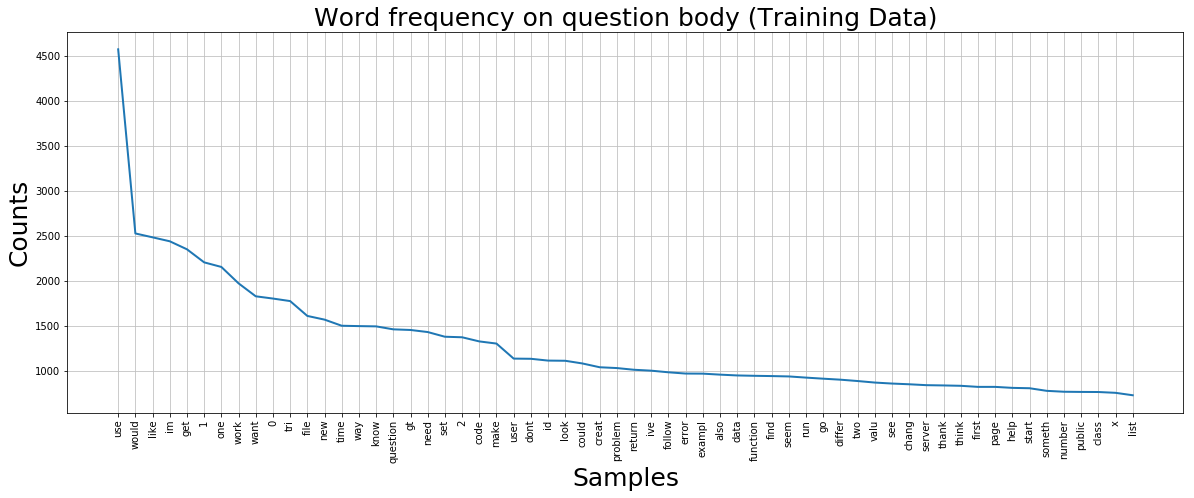

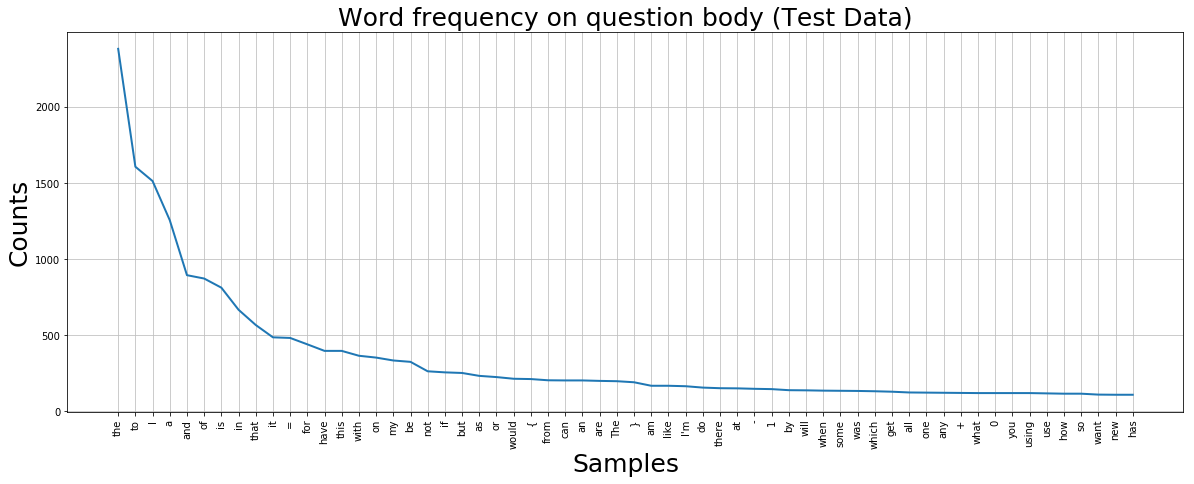

In [ ]:
# training data
freq_dist = FreqDist([word for text in train_data['question_body'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question body (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

# test data
freq_dist = FreqDist([word for text in test_data['question_body'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question body (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

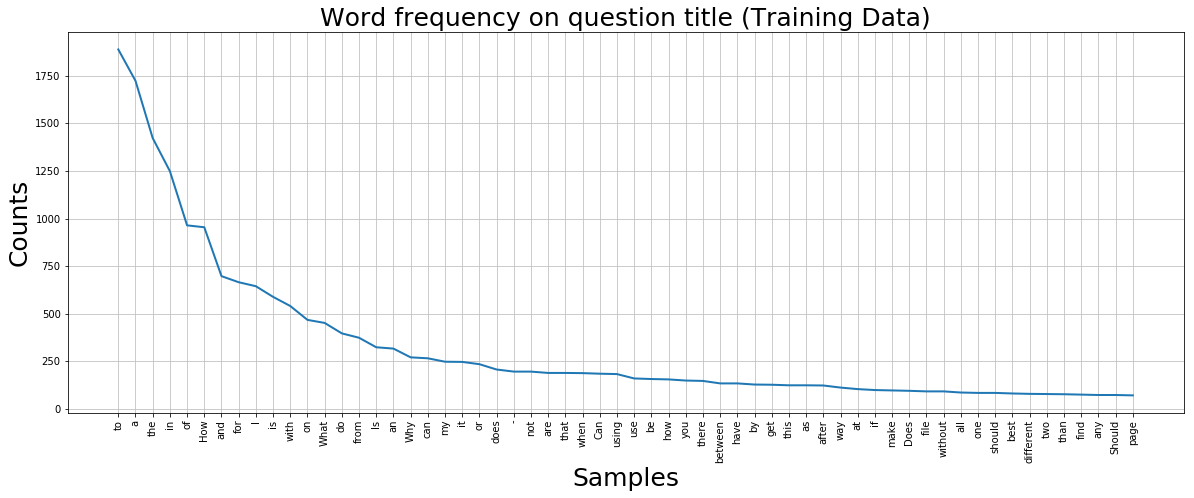

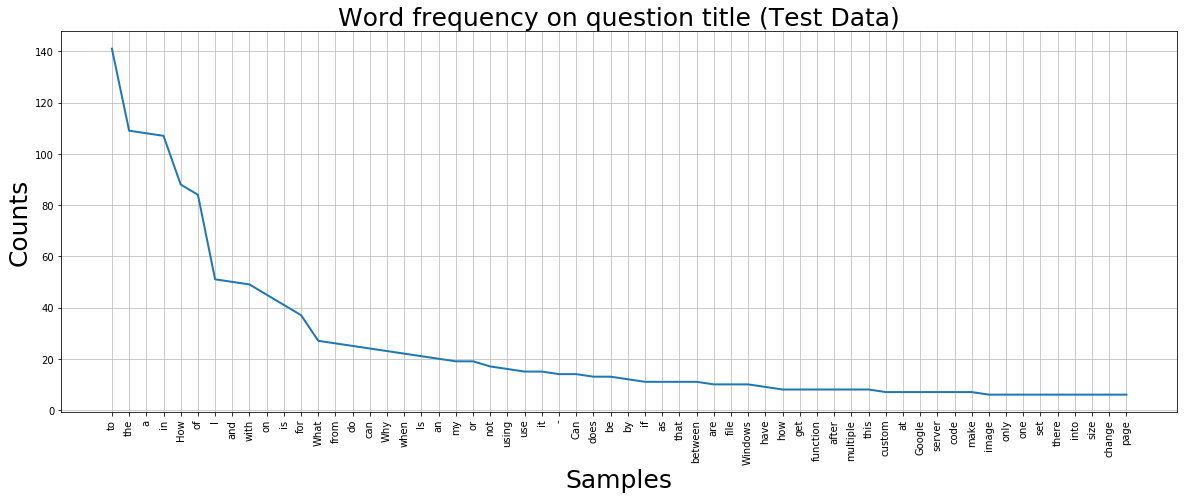

In [ ]:
# training data
freq_dist = FreqDist([word for text in train_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

# test data
freq_dist = FreqDist([word for text in test_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

## utils

In [ ]:
class QUESTDataset(Dataset):
    def __init__(self, df, mode, tokens, augment,
                 tokenizer_type, pretrained_model_name_or_path, do_lower_case,
                 LABEL_COL, t_max_len, q_max_len, a_max_len, tqa_mode,
                 TBSEP, pos_id_type, MAX_SEQUENCE_LENGTH=None,
                 use_category=True, logger=None):
        self.mode = mode
        self.augment = augment
        self.len = len(df)
        self.t_max_len = t_max_len
        self.q_max_len = q_max_len
        self.a_max_len = a_max_len
        self.tqa_mode = tqa_mode
        self.TBSEP = TBSEP
        self.pos_id_type = pos_id_type
        if MAX_SEQUENCE_LENGTH:
            self.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
        else:
            raise NotImplementedError
        self.use_category = use_category
        self.logger = logger
        self.cat_dict = {
            'CAT_TECHNOLOGY'.casefold(): 0,
            'CAT_STACKOVERFLOW'.casefold(): 1,
            'CAT_CULTURE'.casefold(): 2,
            'CAT_SCIENCE'.casefold(): 3,
            'CAT_LIFE_ARTS'.casefold(): 4,
        }

        if mode == "test":
            self.labels = pd.DataFrame([[-1] * len(LABEL_COL)] * len(df))
        else:  # train or valid
            self.labels = df[LABEL_COL]

        self.tokenizer_type = tokenizer_type
        if tokenizer_type == 'bert':
            tokenizer = BertTokenizer
        elif tokenizer_type == 'roberta':
            tokenizer = RobertaTokenizer
        elif tokenizer_type == 'xlnet':
            tokenizer = XLNetTokenizer
        else:
            raise NotImplementedError
        self.tokenizer = tokenizer.from_pretrained(
            pretrained_model_name_or_path, do_lower_case=do_lower_case)
        self.tokenizer.add_tokens([self.TBSEP])

        tokens = [token.encode('ascii', 'replace').decode()
                  for token in tokens if token != '']
        added_num = self.tokenizer.add_tokens(tokens)
        if logger:
            logger.info(f'additional_tokens : {added_num}')
        else:
            print(f'additional_tokens : {added_num}')
        # change online preprocess or off line preprocess
        self.original_df = df

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # change online preprocess or off line preprocess
        idx_row = self.original_df.iloc[idx].copy()
        idx_row = self.__preprocess_text_row(idx_row,
                                             t_max_len=self.t_max_len,
                                             q_max_len=self.q_max_len,
                                             a_max_len=self.a_max_len)
        input_ids = idx_row['input_ids'].squeeze()
        if self.tokenizer_type == 'roberta':
            token_type_ids = torch.zeros(self.MAX_SEQUENCE_LENGTH, dtype=torch.long)
        else:
            token_type_ids = idx_row['token_type_ids'].squeeze()
        attention_mask = idx_row['attention_mask'].squeeze()
        qa_id = idx_row['qa_id'].squeeze()

        if self.pos_id_type == 'arange':
            position_ids = torch.arange(self.MAX_SEQUENCE_LENGTH)
        # elif self.pos_id_type == 'tq_a_sep':
        #     position_ids = torch.cat([
        #         torch.arange(self.t_max_len+self.q_max_len+3),
        #         torch.arange(self.q_max_len+1)])
        # elif self.pos_id_type == 't_q_sep':
        #     position_ids = torch.cat([
        #         torch.arange(self.t_max_len+self.q_max_len+3),
        #         torch.arange(self.q_max_len+1)])
        # elif self.pos_id_type == 't_a_sep':
        #     position_ids = torch.cat(torch.arange(self.t_max_len+self.q_max_len+3)
        #             self.MAX_SEQUENCE_LENGTH)
        else:
            raise NotImplementedError

        labels = self.labels.iloc[idx].values
        return qa_id, input_ids, attention_mask, \
            token_type_ids, position_ids, labels

    def _trim_input(self, title, question, answer,
                    t_max_len, q_max_len, a_max_len):

        t_len = len(title)
        q_len = len(question)
        a_len = len(answer)

        if (t_len + q_len + a_len + 4) > self.MAX_SEQUENCE_LENGTH:
            if t_max_len > t_len:
                t_new_len = t_len
                a_max_len = a_max_len + floor((t_max_len - t_len) / 2)
                q_max_len = q_max_len + ceil((t_max_len - t_len) / 2)
            else:
                t_new_len = t_max_len

            if a_max_len > a_len:
                a_new_len = a_len
                q_new_len = q_max_len + (a_max_len - a_len)
            elif q_max_len > q_len:
                a_new_len = a_max_len + (q_max_len - q_len)
                q_new_len = q_len
            else:
                a_new_len = a_max_len
                q_new_len = q_max_len

            if t_new_len + a_new_len + q_new_len + 4 != self.MAX_SEQUENCE_LENGTH:
                raise ValueError("New sequence length should be %d, but is %d"
                                 % (self.MAX_SEQUENCE_LENGTH,
                                     (t_new_len + a_new_len + q_new_len + 4)))
            if len(title) > t_new_len:
                title = title[:t_new_len // 2] + title[-t_new_len // 2:]
            else:
                title = title[:t_new_len]
            if len(question) > q_new_len:
                question = question[:q_new_len // 2] + \
                    question[-q_new_len // 2:]
            else:
                question = question[:q_new_len]
            if len(answer) > a_new_len:
                answer = answer[:a_new_len // 2] + answer[-a_new_len // 2:]
            else:
                answer = answer[:a_new_len]
        return title, question, answer

    def __preprocess_text_row(self, row, t_max_len, q_max_len, a_max_len):
        qa_id = row.qa_id
        title = self.tokenizer.tokenize(row.question_title)
        body = self.tokenizer.tokenize(row.question_body)
        answer = self.tokenizer.tokenize(row.answer)
        category = ('CAT_' + row.category).casefold()

        # category を text として入れてしまう !!!
        if self.use_category:
            title = [category] + title

        title, body, answer = self._trim_input(title, body, answer,
                                               t_max_len=t_max_len,
                                               q_max_len=q_max_len,
                                               a_max_len=a_max_len)

        if len(title) == 0:
            # print(f'NO TITLE, qa_id: {qa_id}')
            title = ['_']
        if len(body) == 0:
            # print(f'NO BODY, qa_id: {qa_id}')
            body = ['_']
        if len(answer) == 0:
            # print(f'NO ANSWER, qa_id: {qa_id}')
            answer = ['_']

        if self.tqa_mode == 'tq_a':
            text = title + [self.TBSEP] + body
            text_pair = answer
        elif self.tqa_mode == 't_q':
            text = title
            text_pair = body
        elif self.tqa_mode == 't_a':
            text = title
            text_pair = answer

        encoded_texts_dict = self.tokenizer.encode_plus(
            text=text,
            text_pair=text_pair,
            add_special_tokens=True,
            max_length=self.MAX_SEQUENCE_LENGTH,
            pad_to_max_length=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=True,
        )
        encoded_texts_dict['qa_id'] = qa_id
        return encoded_texts_dict

class BertModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, config_path, state_dict,
                 token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(BertModelForBinaryMultiLabelClassifier, self).__init__()
        with open(config_path, 'rb') as fin:
            config = pickle.load(fin)
        self.model = BertModel(config)
        # self.model.load_state_dict(state_dict)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # add modules
        self.add_module('my_fc_output', self.classifier)

    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):

        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids,
                             position_ids=position_ids,
                             head_mask=head_mask,
                             inputs_embeds=inputs_embeds,
                             encoder_hidden_states=encoder_hidden_states,
                             encoder_attention_mask=encoder_attention_mask)

        pooled_output = torch.mean(outputs[0], dim=1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            print('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            print('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    # def _resize_embeddings(self, old_embeddings, new_num_tokens):
    #     old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
    #     if old_num_tokens == new_num_tokens:
    #         return old_embeddings

    #     # Build new embeddings
    #     new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
    #     new_embeddings.to(old_embeddings.weight.device)

    #     # Copy word embeddings from the previous weights
    #     num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
    #     new_embeddings.weight.data[:num_tokens_to_copy,
    #                                :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

    #     return new_embeddings


class RobertaModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, config_path, state_dict,
                 token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(RobertaModelForBinaryMultiLabelClassifier, self).__init__()
        with open(config_path, 'rb') as fin:
            config = pickle.load(fin)
        self.model = RobertaModel(config)
        # self.model.load_state_dict(state_dict)
        # # only for roberta
        # if self.model.state_dict()['embeddings.token_type_embeddings.weight'].shape[0] == 1:
        #     self.model.load_state_dict(state_dict)
        #     self.model.embeddings.token_type_embeddings = self._resize_embeddings(
        #         self.model.embeddings.token_type_embeddings, 2)
        # elif self.model.state_dict()['embeddings.token_type_embeddings.weight'].shape[0] == 2:
        #     self.model.embeddings.token_type_embeddings = self._resize_embeddings(
        #         self.model.embeddings.token_type_embeddings, 2)
        #     self.model.load_state_dict(state_dict)
        # else:
        #     raise NotImplementedError
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # add modules
        self.add_module('my_fc_output', self.classifier)

    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):

        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids,
                             position_ids=position_ids,
                             head_mask=head_mask,
                             inputs_embeds=inputs_embeds,
                             encoder_hidden_states=encoder_hidden_states,
                             encoder_attention_mask=encoder_attention_mask)

        pooled_output = torch.mean(outputs[0], dim=1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            print('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            print('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    # def _resize_embeddings(self, old_embeddings, new_num_tokens):
    #     old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
    #     if old_num_tokens == new_num_tokens:
    #         return old_embeddings

    #     # Build new embeddings
    #     new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
    #     new_embeddings.to(old_embeddings.weight.device)

    #     # Copy word embeddings from the previous weights
    #     num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
    #     new_embeddings.weight.data[:num_tokens_to_copy,
    #                                :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

    #     return new_embeddings


class XLNetModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, config_path, state_dict,
                 token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(XLNetModelForBinaryMultiLabelClassifier, self).__init__()
        with open(config_path, 'rb') as fin:
            config = pickle.load(fin)
        self.model = XLNetModel(config)
        # self.model.load_state_dict(state_dict)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.model.config.d_model, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # add modules
        self.add_module('my_fc_output', self.classifier)

    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):

        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids,
                             # position_ids=position_ids,
                             head_mask=head_mask,
                             inputs_embeds=inputs_embeds,
                             # encoder_hidden_states=encoder_hidden_states,
                             # encoder_attention_mask=encoder_attention_mask
                             )

        pooled_output = torch.mean(outputs[0], dim=1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            print('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            print('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    # def _resize_embeddings(self, old_embeddings, new_num_tokens):
    #     old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
    #     if old_num_tokens == new_num_tokens:
    #         return old_embeddings

    #     # Build new embeddings
    #     new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
    #     new_embeddings.to(old_embeddings.weight.device)

    #     # Copy word embeddings from the previous weights
    #     num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
    #     new_embeddings.weight.data[:num_tokens_to_copy,
    #                                :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

    #     return new_embeddings

def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(
                col_trues,
                col_pred +
                np.random.normal(
                    0,
                    1e-7,
                    col_pred.shape[0])).correlation)
    return rhos


def train_one_epoch(model, fobj, optimizer, loader, DEVICE):
    model.train()

    running_loss = 0
    for (qa_id, input_ids, attention_mask,
         token_type_ids, position_ids, labels) in tqdm(loader):
        # send them to DEVICE
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        token_type_ids = token_type_ids.to(DEVICE)
        position_ids = position_ids.to(DEVICE)
        labels = labels.to(DEVICE)

        # forward
        outputs = model(
            input_ids=input_ids,
            labels=labels,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids
        )
        loss = fobj(outputs[0], labels.float())

        # backword and update
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # store loss to culc epoch mean
        running_loss += loss

    loss_mean = running_loss / len(loader)

    return loss_mean


def test(model, fobj, loader, DEVICE, mode):
    model.eval()

    with torch.no_grad():
        y_preds, y_trues, qa_ids = [], [], []

        running_loss = 0
        for (qa_id, input_ids, attention_mask,
             token_type_ids, position_ids, labels) in tqdm(loader):
            # send them to DEVICE
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)
            position_ids = position_ids.to(DEVICE)
            labels = labels.to(DEVICE)

            # forward
            outputs = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids
            )
            logits = outputs[0]
            if mode != 'test':
                loss = fobj(logits, labels.float())

                running_loss += loss

            y_preds.append(torch.sigmoid(logits))
            y_trues.append(labels)
            qa_ids.append(qa_id)

        loss_mean = running_loss / len(loader)

        y_preds = torch.cat(y_preds).to('cpu').numpy()
        y_trues = torch.cat(y_trues).to('cpu').numpy()
        qa_ids = torch.cat(qa_ids).to('cpu').numpy()

        if mode == 'valid':
            metric_raws = compute_spearmanr(y_trues, y_preds)
            metric = np.mean(metric_raws)
        elif mode != 'test':
            raise NotImplementedError
        else:
            metric_raws = None
            metric = None

    return loss_mean, metric, metric_raws, y_preds, y_trues, qa_ids


def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

## BERT

In [ ]:
#%debug
# prediction_loop
import os
import gc
import pickle

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


FOLD_NUM = 5
RANK_NUM = 1

state_dict = {}

#############################
#  BERT QUESTION
#############################
bert_question_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BERT_Q_BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = BertModelForBinaryMultiLabelClassifier(21, BERT_BASE_MODEL_PATH, state_dict, token_size=30528, )
        model.load_state_dict(state_dict)
        model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            augment=[],
            tokenizer_type='bert',
            pretrained_model_name_or_path=BERT_Q_BASE_PATH,
            do_lower_case=True,
            LABEL_COL=Q_LABEL_COL,
            t_max_len=30,
            q_max_len=239 * 2,
            a_max_len=239 * 0,
            tqa_mode='tq_a',
            TBSEP='[TBSEP]',
            pos_id_type='arange',
            MAX_SEQUENCE_LENGTH=512,
        )

        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        _, _, _, y_preds, _, qa_ids = test(model, None, test_loader, DEVICE, 'test')

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in bert_question_fold_prediction_dict:
            bert_question_fold_prediction_dict[fold] += fold_df
        else:
            bert_question_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    bert_question_fold_prediction_dict[fold] = bert_question_fold_prediction_dict[fold] / RANK_NUM #AVG


#############################
#  BERT ANSWER
#############################
FOLD_NUM = 5
RANK_NUM = 1

bert_answer_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BERT_A_BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = BertModelForBinaryMultiLabelClassifier(9, BERT_BASE_MODEL_PATH, state_dict, token_size=30528, )
        model.load_state_dict(state_dict)
        model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            augment=[],
            tokenizer_type='bert',
            pretrained_model_name_or_path=BERT_A_BASE_PATH,
            do_lower_case=True,
            LABEL_COL=A_LABEL_COL,
            t_max_len=30,
            q_max_len=239 * 0,
            a_max_len=239 * 2,
            tqa_mode='tq_a',
            TBSEP='[TBSEP]',
            pos_id_type='arange',
            MAX_SEQUENCE_LENGTH=512,
        )

        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        _, _, _, y_preds, _, qa_ids = test(model, None, test_loader, DEVICE, 'test')

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in bert_answer_fold_prediction_dict:
            bert_answer_fold_prediction_dict[fold] += fold_df
        else:
            bert_answer_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    bert_answer_fold_prediction_dict[fold] = bert_answer_fold_prediction_dict[fold] / RANK_NUM #AVG

bert_fold_prediction_dict = {}
for fold in bert_question_fold_prediction_dict:
    bert_fold_prediction_dict[fold] = bert_question_fold_prediction_dict[fold].reset_index().merge(
                                      bert_answer_fold_prediction_dict[fold].reset_index(), on='qa_id', how='left')

fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [ ]:
bert_fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0     1398  0.847796  0.440926  0.020447  0.551570  0.943091  0.962048   
1     4792  0.866912  0.502120  0.003711  0.824747  0.763582  0.943328   
2     5001  0.866815  0.507707  0.002730  0.850120  0.718377  0.964389   
3     9018  0.925929  0.617969  0.018494  0.702415  0.858799  0.966494   
4      292  0.951799  0.696922  0.009028  0.928473  0.816911  0.963912   
..     ...       ...       ...       ...       ...       ...       ...   
471   8672  0.843359  0.483258  0.002774  0.732659  0.797538  0.969384   
472   5697  0.870337  0.619217  0.006183  0.776442  0.618323  0.933225   
473   6212  0.885937  0.506405  0.010525  0.868521  0.751793  0.959160   
474   3463  0.913969  0.800634  0.003832  0.859309  0.782339  0.942338   
475   7485  0.771430  0.475366  0.012149  0.776776  0.591893  0.938125   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.625357  0.503745  0.806341  ...  0.792012  0.854388  0.567816   
1    0.544321  0.431128  0.017825  ...  0.703832  0.880550  0.604622   
2    0.510051  0.402267  0.028103  ...  0.706633  0.928070  0.613593   
3    0.733884  0.571648  0.442688  ...  0.874118  0.910336  0.589681   
4    0.672432  0.527882  0.023119  ...  0.855292  0.935052  0.613759   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.474902  0.352495  0.030330  ...  0.654103  0.961007  0.688178   
472  0.439790  0.372814  0.032814  ...  0.762565  0.897336  0.602782   
473  0.554832  0.405817  0.031328  ...  0.744220  0.840899  0.536831   
474  0.536575  0.397007  0.013347  ...  0.857432  0.859431  0.543834   
475  0.439702  0.393027  0.006918  ...  0.606035  0.944567  0.621642   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.912477  0.944552  0.767660  0.017264  0.015279  0.924710  0.870750  
1    0.940556  0.961293  0.837844  0.434677  0.092244  0.465726  0.905462  
2    0.943809  0.986276  0.891532  0.931183  0.111452  0.037878  0.883913  
3    0.965053  0.976254  0.880870  0.027267  0.015457  0.963975  0.896286  
4    0.973547  0.983070  0.881255  0.153000  0.052487  0.958210  0.920070  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.968422  0.992491  0.936612  0.922143  0.174015  0.165439  0.919076  
472  0.927120  0.967097  0.873324  0.822833  0.195964  0.152599  0.876986  
473  0.906925  0.937644  0.734739  0.123540  0.044025  0.917698  0.778643  
474  0.919889  0.940834  0.841185  0.681924  0.059844  0.026918  0.843198  
475  0.968507  0.979668  0.891449  0.559656  0.125280  0.748439  0.916659  

[476 rows x 31 columns]

## ROBERTA

In [ ]:
# %debug
FOLD_NUM = 5
RANK_NUM = 2

state_dict = {}

#############################
#  ROBERTA QUESTION
#############################
roberta_question_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{ROBERTA_Q_BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = RobertaModelForBinaryMultiLabelClassifier(21, ROBERTA_BASE_MODEL_PATH, state_dict, token_size=50271, )
        model.load_state_dict(state_dict)
        model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            augment=[],
            tokenizer_type='roberta',
            pretrained_model_name_or_path=ROBERTA_Q_BASE_PATH,
            do_lower_case=False,
            LABEL_COL=Q_LABEL_COL,
            t_max_len=30,
            q_max_len=239 * 2,
            a_max_len=239 * 0,
            tqa_mode='tq_a',
            TBSEP='[TBSEP]',
            pos_id_type='arange',
            MAX_SEQUENCE_LENGTH=512,
        )

        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        _, _, _, y_preds, _, qa_ids = test(model, None, test_loader, DEVICE, 'test')

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in roberta_question_fold_prediction_dict:
            roberta_question_fold_prediction_dict[fold] += fold_df
        else:
            roberta_question_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    roberta_question_fold_prediction_dict[fold] = roberta_question_fold_prediction_dict[fold] / RANK_NUM #AVG


#############################
#  ROBERTA ANSWER
#############################
FOLD_NUM = 5
RANK_NUM = 2

roberta_answer_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{ROBERTA_A_BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = RobertaModelForBinaryMultiLabelClassifier(9, ROBERTA_BASE_MODEL_PATH, state_dict, token_size=50271, )
        model.load_state_dict(state_dict)
        model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            augment=[],
            tokenizer_type='roberta',
            pretrained_model_name_or_path=ROBERTA_A_BASE_PATH,
            do_lower_case=False,
            LABEL_COL=A_LABEL_COL,
            t_max_len=30,
            q_max_len=239 * 0,
            a_max_len=239 * 2,
            tqa_mode='tq_a',
            TBSEP='[TBSEP]',
            pos_id_type='arange',
            MAX_SEQUENCE_LENGTH=512,
        )

        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        _, _, _, y_preds, _, qa_ids = test(model, None, test_loader, DEVICE, 'test')

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in roberta_answer_fold_prediction_dict:
            roberta_answer_fold_prediction_dict[fold] += fold_df
        else:
            roberta_answer_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    roberta_answer_fold_prediction_dict[fold] = roberta_answer_fold_prediction_dict[fold] / RANK_NUM #AVG

roberta_fold_prediction_dict = {}
for fold in roberta_question_fold_prediction_dict:
    roberta_fold_prediction_dict[fold] = roberta_question_fold_prediction_dict[fold].reset_index().merge(
                                      roberta_answer_fold_prediction_dict[fold].reset_index(), on='qa_id', how='left')

fold -- 0
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [ ]:
roberta_fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0      962  0.914140  0.480334  0.004785  0.568735  0.759629  0.869871   
1     7838  0.853426  0.507326  0.006297  0.686286  0.766104  0.901784   
2     7485  0.848429  0.472255  0.006073  0.786050  0.655759  0.937584   
3     8771  0.947310  0.455630  0.013029  0.757451  0.861680  0.894324   
4      257  0.849269  0.499030  0.001929  0.766835  0.719129  0.953901   
..     ...       ...       ...       ...       ...       ...       ...   
471   4598  0.907718  0.736048  0.006265  0.695508  0.862286  0.917702   
472   4070  0.900051  0.585832  0.002118  0.747328  0.694298  0.948432   
473   6379  0.906072  0.560217  0.007815  0.648629  0.974649  0.906662   
474   8273  0.948253  0.672032  0.002324  0.690648  0.809507  0.918684   
475   3207  0.772779  0.391133  0.002180  0.588107  0.801006  0.947852   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.572828  0.424127  0.675561  ...  0.758088  0.878383  0.557621   
1    0.543810  0.412218  0.159883  ...  0.760990  0.937442  0.672637   
2    0.530268  0.402721  0.011078  ...  0.652962  0.871796  0.588736   
3    0.688825  0.633999  0.037291  ...  0.714120  0.851333  0.619289   
4    0.501961  0.353582  0.033527  ...  0.741188  0.936365  0.674781   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.640297  0.473055  0.454903  ...  0.918125  0.930691  0.659400   
472  0.539590  0.390227  0.022624  ...  0.767331  0.944368  0.659498   
473  0.622600  0.597616  0.842005  ...  0.875742  0.916750  0.672333   
474  0.639786  0.484545  0.462060  ...  0.895924  0.953804  0.633984   
475  0.498496  0.341717  0.639601  ...  0.669627  0.979168  0.669464   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.942191  0.953975  0.749083  0.850935  0.178009  0.067369  0.900107  
1    0.951715  0.979962  0.866933  0.885096  0.214744  0.361323  0.901100  
2    0.929241  0.959566  0.812205  0.481190  0.133918  0.597440  0.865162  
3    0.934347  0.940403  0.791641  0.029751  0.013105  0.995164  0.855106  
4    0.950539  0.982481  0.880433  0.923425  0.207832  0.333520  0.857973  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.958592  0.976042  0.878827  0.575187  0.135909  0.947554  0.909361  
472  0.963994  0.981023  0.857183  0.763543  0.266634  0.730052  0.914287  
473  0.959293  0.973595  0.839394  0.065776  0.056305  0.901923  0.948582  
474  0.975746  0.987060  0.865473  0.926153  0.153340  0.077730  0.935515  
475  0.983369  0.994834  0.932908  0.910620  0.212868  0.363382  0.952489  

[476 rows x 31 columns]

In [ ]:
bert_fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0     1398  0.847796  0.440926  0.020447  0.551570  0.943091  0.962048   
1     4792  0.866912  0.502120  0.003711  0.824747  0.763582  0.943328   
2     5001  0.866815  0.507707  0.002730  0.850120  0.718377  0.964389   
3     9018  0.925929  0.617969  0.018494  0.702415  0.858799  0.966494   
4      292  0.951799  0.696922  0.009028  0.928473  0.816911  0.963912   
..     ...       ...       ...       ...       ...       ...       ...   
471   8672  0.843359  0.483258  0.002774  0.732659  0.797538  0.969384   
472   5697  0.870337  0.619217  0.006183  0.776442  0.618323  0.933225   
473   6212  0.885937  0.506405  0.010525  0.868521  0.751793  0.959160   
474   3463  0.913969  0.800634  0.003832  0.859309  0.782339  0.942338   
475   7485  0.771430  0.475366  0.012149  0.776776  0.591893  0.938125   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.625357  0.503745  0.806341  ...  0.792012  0.854388  0.567816   
1    0.544321  0.431128  0.017825  ...  0.703832  0.880550  0.604622   
2    0.510051  0.402267  0.028103  ...  0.706633  0.928070  0.613593   
3    0.733884  0.571648  0.442688  ...  0.874118  0.910336  0.589681   
4    0.672432  0.527882  0.023119  ...  0.855292  0.935052  0.613759   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.474902  0.352495  0.030330  ...  0.654103  0.961007  0.688178   
472  0.439790  0.372814  0.032814  ...  0.762565  0.897336  0.602782   
473  0.554832  0.405817  0.031328  ...  0.744220  0.840899  0.536831   
474  0.536575  0.397007  0.013347  ...  0.857432  0.859431  0.543834   
475  0.439702  0.393027  0.006918  ...  0.606035  0.944567  0.621642   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.912477  0.944552  0.767660  0.017264  0.015279  0.924710  0.870750  
1    0.940556  0.961293  0.837844  0.434677  0.092244  0.465726  0.905462  
2    0.943809  0.986276  0.891532  0.931183  0.111452  0.037878  0.883913  
3    0.965053  0.976254  0.880870  0.027267  0.015457  0.963975  0.896286  
4    0.973547  0.983070  0.881255  0.153000  0.052487  0.958210  0.920070  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.968422  0.992491  0.936612  0.922143  0.174015  0.165439  0.919076  
472  0.927120  0.967097  0.873324  0.822833  0.195964  0.152599  0.876986  
473  0.906925  0.937644  0.734739  0.123540  0.044025  0.917698  0.778643  
474  0.919889  0.940834  0.841185  0.681924  0.059844  0.026918  0.843198  
475  0.968507  0.979668  0.891449  0.559656  0.125280  0.748439  0.916659  

[476 rows x 31 columns]

## XLNet

In [ ]:
# %debug
FOLD_NUM = 5
RANK_NUM = 1

state_dict = {}

#############################
#  XLNET QUESTION
#############################
xlnet_question_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{XLNET_Q_BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = XLNetModelForBinaryMultiLabelClassifier(21, XLNET_BASE_MODEL_PATH, state_dict, token_size=32006, )
        model.load_state_dict(state_dict)
        model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            augment=[],
            tokenizer_type='xlnet',
            pretrained_model_name_or_path=XLNET_Q_BASE_PATH,
            do_lower_case=False,
            LABEL_COL=Q_LABEL_COL,
            t_max_len=30,
            q_max_len=239 * 2,
            a_max_len=239 * 0,
            tqa_mode='tq_a',
            TBSEP='[TBSEP]',
            pos_id_type='arange',
            MAX_SEQUENCE_LENGTH=512,
        )

        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        _, _, _, y_preds, _, qa_ids = test(model, None, test_loader, DEVICE, 'test')

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in xlnet_question_fold_prediction_dict:
            xlnet_question_fold_prediction_dict[fold] += fold_df
        else:
            xlnet_question_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    xlnet_question_fold_prediction_dict[fold] = xlnet_question_fold_prediction_dict[fold] / RANK_NUM #AVG


#############################
#  XLNET ANSWER
#############################
FOLD_NUM = 5
RANK_NUM = 1

xlnet_answer_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{XLNET_A_BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = XLNetModelForBinaryMultiLabelClassifier(9, XLNET_BASE_MODEL_PATH, state_dict, token_size=32006, )
        model.load_state_dict(state_dict)
        model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            augment=[],
            tokenizer_type='xlnet',
            pretrained_model_name_or_path=XLNET_A_BASE_PATH,
            do_lower_case=False,
            LABEL_COL=A_LABEL_COL,
            t_max_len=30,
            q_max_len=239 * 0,
            a_max_len=239 * 2,
            tqa_mode='tq_a',
            TBSEP='[TBSEP]',
            pos_id_type='arange',
            MAX_SEQUENCE_LENGTH=512,
        )

        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        _, _, _, y_preds, _, qa_ids = test(model, None, test_loader, DEVICE, 'test')

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in xlnet_answer_fold_prediction_dict:
            xlnet_answer_fold_prediction_dict[fold] += fold_df
        else:
            xlnet_answer_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    xlnet_answer_fold_prediction_dict[fold] = xlnet_answer_fold_prediction_dict[fold] / RANK_NUM #AVG

xlnet_fold_prediction_dict = {}
for fold in xlnet_question_fold_prediction_dict:
    xlnet_fold_prediction_dict[fold] = xlnet_question_fold_prediction_dict[fold].reset_index().merge(
                                      xlnet_answer_fold_prediction_dict[fold].reset_index(), on='qa_id', how='left')

fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [ ]:
bert_fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0     1398  0.847796  0.440926  0.020447  0.551570  0.943091  0.962048   
1     4792  0.866912  0.502120  0.003711  0.824747  0.763582  0.943328   
2     5001  0.866815  0.507707  0.002730  0.850120  0.718377  0.964389   
3     9018  0.925929  0.617969  0.018494  0.702415  0.858799  0.966494   
4      292  0.951799  0.696922  0.009028  0.928473  0.816911  0.963912   
..     ...       ...       ...       ...       ...       ...       ...   
471   8672  0.843359  0.483258  0.002774  0.732659  0.797538  0.969384   
472   5697  0.870337  0.619217  0.006183  0.776442  0.618323  0.933225   
473   6212  0.885937  0.506405  0.010525  0.868521  0.751793  0.959160   
474   3463  0.913969  0.800634  0.003832  0.859309  0.782339  0.942338   
475   7485  0.771430  0.475366  0.012149  0.776776  0.591893  0.938125   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.625357  0.503745  0.806341  ...  0.792012  0.854388  0.567816   
1    0.544321  0.431128  0.017825  ...  0.703832  0.880550  0.604622   
2    0.510051  0.402267  0.028103  ...  0.706633  0.928070  0.613593   
3    0.733884  0.571648  0.442688  ...  0.874118  0.910336  0.589681   
4    0.672432  0.527882  0.023119  ...  0.855292  0.935052  0.613759   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.474902  0.352495  0.030330  ...  0.654103  0.961007  0.688178   
472  0.439790  0.372814  0.032814  ...  0.762565  0.897336  0.602782   
473  0.554832  0.405817  0.031328  ...  0.744220  0.840899  0.536831   
474  0.536575  0.397007  0.013347  ...  0.857432  0.859431  0.543834   
475  0.439702  0.393027  0.006918  ...  0.606035  0.944567  0.621642   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.912477  0.944552  0.767660  0.017264  0.015279  0.924710  0.870750  
1    0.940556  0.961293  0.837844  0.434677  0.092244  0.465726  0.905462  
2    0.943809  0.986276  0.891532  0.931183  0.111452  0.037878  0.883913  
3    0.965053  0.976254  0.880870  0.027267  0.015457  0.963975  0.896286  
4    0.973547  0.983070  0.881255  0.153000  0.052487  0.958210  0.920070  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.968422  0.992491  0.936612  0.922143  0.174015  0.165439  0.919076  
472  0.927120  0.967097  0.873324  0.822833  0.195964  0.152599  0.876986  
473  0.906925  0.937644  0.734739  0.123540  0.044025  0.917698  0.778643  
474  0.919889  0.940834  0.841185  0.681924  0.059844  0.026918  0.843198  
475  0.968507  0.979668  0.891449  0.559656  0.125280  0.748439  0.916659  

[476 rows x 31 columns]

In [ ]:
roberta_fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0      962  0.914140  0.480334  0.004785  0.568735  0.759629  0.869871   
1     7838  0.853426  0.507326  0.006297  0.686286  0.766104  0.901784   
2     7485  0.848429  0.472255  0.006073  0.786050  0.655759  0.937584   
3     8771  0.947310  0.455630  0.013029  0.757451  0.861680  0.894324   
4      257  0.849269  0.499030  0.001929  0.766835  0.719129  0.953901   
..     ...       ...       ...       ...       ...       ...       ...   
471   4598  0.907718  0.736048  0.006265  0.695508  0.862286  0.917702   
472   4070  0.900051  0.585832  0.002118  0.747328  0.694298  0.948432   
473   6379  0.906072  0.560217  0.007815  0.648629  0.974649  0.906662   
474   8273  0.948253  0.672032  0.002324  0.690648  0.809507  0.918684   
475   3207  0.772779  0.391133  0.002180  0.588107  0.801006  0.947852   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.572828  0.424127  0.675561  ...  0.758088  0.878383  0.557621   
1    0.543810  0.412218  0.159883  ...  0.760990  0.937442  0.672637   
2    0.530268  0.402721  0.011078  ...  0.652962  0.871796  0.588736   
3    0.688825  0.633999  0.037291  ...  0.714120  0.851333  0.619289   
4    0.501961  0.353582  0.033527  ...  0.741188  0.936365  0.674781   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.640297  0.473055  0.454903  ...  0.918125  0.930691  0.659400   
472  0.539590  0.390227  0.022624  ...  0.767331  0.944368  0.659498   
473  0.622600  0.597616  0.842005  ...  0.875742  0.916750  0.672333   
474  0.639786  0.484545  0.462060  ...  0.895924  0.953804  0.633984   
475  0.498496  0.341717  0.639601  ...  0.669627  0.979168  0.669464   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.942191  0.953975  0.749083  0.850935  0.178009  0.067369  0.900107  
1    0.951715  0.979962  0.866933  0.885096  0.214744  0.361323  0.901100  
2    0.929241  0.959566  0.812205  0.481190  0.133918  0.597440  0.865162  
3    0.934347  0.940403  0.791641  0.029751  0.013105  0.995164  0.855106  
4    0.950539  0.982481  0.880433  0.923425  0.207832  0.333520  0.857973  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.958592  0.976042  0.878827  0.575187  0.135909  0.947554  0.909361  
472  0.963994  0.981023  0.857183  0.763543  0.266634  0.730052  0.914287  
473  0.959293  0.973595  0.839394  0.065776  0.056305  0.901923  0.948582  
474  0.975746  0.987060  0.865473  0.926153  0.153340  0.077730  0.935515  
475  0.983369  0.994834  0.932908  0.910620  0.212868  0.363382  0.952489  

[476 rows x 31 columns]

In [ ]:
xlnet_fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0      962  0.914182  0.560236  0.007036  0.553421  0.769852  0.856947   
1     5904  0.928461  0.649434  0.013858  0.455552  0.843568  0.575391   
2     3378  0.884070  0.731428  0.006196  0.875423  0.869864  0.907638   
3     2303  0.988709  0.873212  0.185734  0.962714  0.216319  0.120451   
4     4281  0.952226  0.897723  0.633084  0.292071  0.480986  0.338250   
..     ...       ...       ...       ...       ...       ...       ...   
471   5373  0.645797  0.408694  0.025010  0.623538  0.777572  0.778480   
472   8197  0.869444  0.630507  0.009415  0.764362  0.804105  0.927571   
473    322  0.898700  0.623827  0.006470  0.688943  0.706958  0.889764   
474   9141  0.897650  0.509706  0.002120  0.728698  0.761707  0.930904   
475   8987  0.983112  0.839816  0.027416  0.745788  0.890307  0.873975   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.617526  0.462827  0.737723  ...  0.825854  0.894095  0.616417   
1    0.593749  0.507910  0.702953  ...  0.847296  0.964556  0.761167   
2    0.523027  0.376282  0.081558  ...  0.756552  0.946426  0.674709   
3    0.711159  0.871006  0.013680  ...  0.969060  0.904132  0.681827   
4    0.759590  0.841178  0.680588  ...  0.980487  0.858604  0.607390   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.511048  0.340325  0.281908  ...  0.669716  0.822537  0.633457   
472  0.522034  0.366572  0.594033  ...  0.873186  0.939274  0.679597   
473  0.552516  0.432763  0.559475  ...  0.843085  0.949906  0.689240   
474  0.536812  0.392164  0.082669  ...  0.730050  0.951433  0.685866   
475  0.816844  0.784015  0.422627  ...  0.960443  0.940419  0.677923   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.951276  0.958253  0.814385  0.862480  0.131067  0.098869  0.915470  
1    0.982303  0.991406  0.932751  0.847431  0.167900  0.330164  0.970593  
2    0.962256  0.981794  0.874285  0.929928  0.121291  0.075476  0.921337  
3    0.960622  0.969558  0.868859  0.046523  0.015742  0.567020  0.971191  
4    0.935159  0.948740  0.856911  0.009461  0.007376  0.844893  0.950045  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.897261  0.925350  0.787579  0.279638  0.112185  0.342004  0.905071  
472  0.968803  0.985728  0.882235  0.898319  0.116849  0.209353  0.936715  
473  0.964346  0.987425  0.901958  0.958947  0.125344  0.073998  0.921545  
474  0.968800  0.988598  0.914913  0.958733  0.117968  0.098441  0.910781  
475  0.979219  0.986027  0.916837  0.035806  0.023678  0.958041  0.943589  

[476 rows x 31 columns]

#### merge all fold prediction dicts

In [ ]:
fold_prediction_dict = {}

dicts = [bert_fold_prediction_dict, roberta_fold_prediction_dict, xlnet_fold_prediction_dict]

for _fold_prediction_dict in dicts:
    for fold in _fold_prediction_dict:
        if fold in fold_prediction_dict:
            fold_prediction_dict[fold] += _fold_prediction_dict[fold].sort_values('qa_id').reset_index(drop=True)
        else:
            fold_prediction_dict[fold] = _fold_prediction_dict[fold].sort_values('qa_id').reset_index(drop=True)#.copy()

for fold in fold_prediction_dict:
    fold_prediction_dict[fold] /= len(dicts)

In [ ]:
fold_prediction_dict[0]

qa_id       0_x       1_x       2_x       3_x       4_x       5_x  \
0      39.0  0.954917  0.710657  0.294701  0.471328  0.457185  0.499222   
1      46.0  0.873780  0.473235  0.002121  0.794008  0.721475  0.963219   
2      70.0  0.911512  0.772223  0.010604  0.873960  0.906724  0.983491   
3     132.0  0.878628  0.442680  0.002438  0.705541  0.753865  0.926497   
4     200.0  0.942570  0.437602  0.008158  0.904553  0.777264  0.966997   
..      ...       ...       ...       ...       ...       ...       ...   
471  9569.0  0.853598  0.517528  0.002626  0.785772  0.725537  0.955987   
472  9590.0  0.871032  0.492038  0.007884  0.656174  0.737587  0.853849   
473  9597.0  0.788932  0.315487  0.010535  0.693635  0.768574  0.934278   
474  9623.0  0.889857  0.848617  0.020686  0.950134  0.884352  0.980730   
475  9640.0  0.905804  0.654107  0.003189  0.902831  0.754219  0.973954   

          6_x       7_x       8_x  ...        20       0_y       1_y  \
0    0.738751  0.704749  0.610821  ...  0.948840  0.857214  0.550174   
1    0.530037  0.421044  0.098874  ...  0.615918  0.947409  0.664653   
2    0.569413  0.410478  0.045221  ...  0.921192  0.939162  0.581710   
3    0.520436  0.389251  0.067317  ...  0.691788  0.960524  0.697259   
4    0.726097  0.635737  0.083383  ...  0.697727  0.812041  0.560580   
..        ...       ...       ...  ...       ...       ...       ...   
471  0.519477  0.388194  0.040725  ...  0.681175  0.954524  0.694808   
472  0.489750  0.412428  0.041520  ...  0.651146  0.931601  0.639898   
473  0.493897  0.367937  0.611971  ...  0.626999  0.886898  0.593244   
474  0.587042  0.403140  0.035923  ...  0.926015  0.982687  0.750963   
475  0.630500  0.535984  0.039496  ...  0.756587  0.942270  0.663925   

          2_y       3_y       4_y       5_y       6_y       7_y       8_y  
0    0.919860  0.926816  0.744660  0.026427  0.017135  0.786841  0.926908  
1    0.965220  0.987213  0.902491  0.947818  0.107163  0.036286  0.909706  
2    0.974878  0.983145  0.871931  0.080049  0.031259  0.898137  0.926188  
3    0.974255  0.990842  0.925087  0.854703  0.157005  0.690286  0.922251  
4    0.908153  0.916927  0.729495  0.064419  0.056915  0.440876  0.893649  
..        ...       ...       ...       ...       ...       ...       ...  
471  0.963155  0.991337  0.931746  0.940073  0.129162  0.067769  0.903959  
472  0.952881  0.982143  0.890177  0.935127  0.105458  0.043798  0.902337  
473  0.945096  0.956989  0.794066  0.348584  0.126574  0.639378  0.929604  
474  0.988525  0.995371  0.970537  0.040751  0.049991  0.890443  0.961587  
475  0.967579  0.980762  0.894223  0.739797  0.136431  0.111738  0.913789  

[476 rows x 31 columns]

#### ensemble

In [ ]:
def convert_folds_prediction_to_sub(folds_prediction_dict):
    for i, fold in enumerate(folds_prediction_dict):
        if i == 0:
            prediction = folds_prediction_dict[fold].sort_values('qa_id').set_index('qa_id').values
        else:
            prediction += folds_prediction_dict[fold].sort_values('qa_id').set_index('qa_id').values
#    sub_df = pd.DataFrame(base_prediction)
#    sub_df['qa_id'] = folds_prediction_dict[fold]['qa_id'].sort_values().values
    prediction /= len(folds_prediction_dict)
    return prediction

In [ ]:
prediction = convert_folds_prediction_to_sub(fold_prediction_dict)

In [ ]:
raw_prediction = prediction.copy()

## opt

In [ ]:
import pickle
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels

In [ ]:
#with open('/kaggle/input/e059-question-snapshot/optRs.pkl', 'rb') as fin:
#    optRs = pickle.load(fin)
#with open('/kaggle/input/e060-answer-snapshot/optRs.pkl', 'rb') as fin:
#    optRs += pickle.load(fin)

with open('/kaggle/input/sub-e121-e129-bert1-roberta2-xlnet1/optRs.pkl', 'rb') as fin:
    optRs = pickle.load(fin)

In [ ]:
res_prediction = []
for i in tqdm(list(range(30))):
    y_pred = prediction[:, i]
    #if i not in [2,4,5,6,7,11,12,13,14,15,16,18,19,29]:
    # if i not in [2,4,5,6,7,8,9,11,12,13,14,15,16,19,23,25,]:
    # if i not in [2,4,5,6,7,8,11,12,13,14,15,16,19,23,25,]:
    # if i not in [2,4,5,6,7,8,11,12,13,14,15,16,23,25,]:
    if i not in [2,4,5,6,7,8,9,11,12,13,14,15,16,19,23,25,]:
        res_prediction.append(y_pred)
        continue

    optR = optRs[i]
    res = optR.predict(y_pred, optR.coefficients()).astype(float)

    res_prediction.append(res)

prediction = np.asarray(res_prediction).T

100%|██████████| 30/30 [00:00<00:00, 1336.52it/s]


In [ ]:
raw_prediction[:, 0]

array([0.95375264, 0.8649542 , 0.90528715, 0.87796974, 0.9374218 ,
       0.933047  , 0.8594923 , 0.96472377, 0.8579386 , 0.95046186,
       0.8571246 , 0.95266265, 0.8713151 , 0.87348235, 0.7170374 ,
       0.75823057, 0.6978021 , 0.90218097, 0.97226924, 0.9759364 ,
       0.8692311 , 0.8226098 , 0.91723174, 0.9000343 , 0.9861704 ,
       0.8583479 , 0.615074  , 0.7624933 , 0.7737828 , 0.7794051 ,
       0.8436349 , 0.86244315, 0.6895728 , 0.81835186, 0.93087864,
       0.9446448 , 0.74102706, 0.95630646, 0.96478474, 0.8775145 ,
       0.80207014, 0.86480606, 0.89141524, 0.85117835, 0.81387365,
       0.9540664 , 0.9337498 , 0.89689434, 0.8605323 , 0.792968  ,
       0.9261715 , 0.9537018 , 0.70293325, 0.96083164, 0.81826055,
       0.8406623 , 0.93725455, 0.8011571 , 0.95846254, 0.7422961 ,
       0.8677433 , 0.84610397, 0.9390007 , 0.85525334, 0.8028625 ,
       0.92079276, 0.96785176, 0.85555106, 0.9730967 , 0.6860186 ,
       0.87324095, 0.9481869 , 0.86763984, 0.9018532 , 0.94636

In [ ]:
optRs[0].coefficients()

array([0.76385733, 0.72411944, 0.76963777, 0.72738918, 0.80888326,
       0.87647534, 0.91044038, 0.9441074 ])

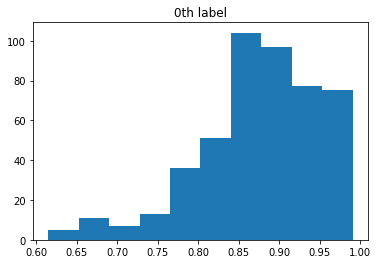

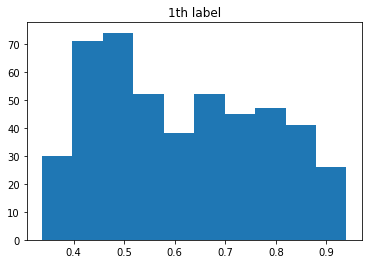

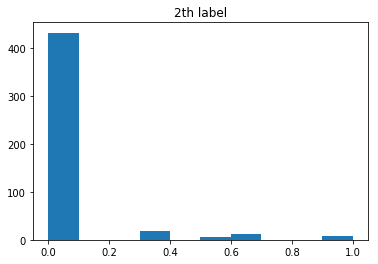

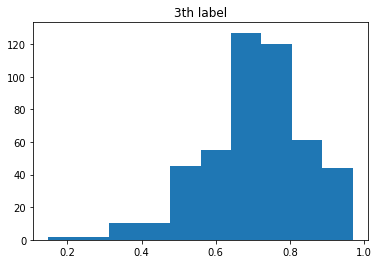

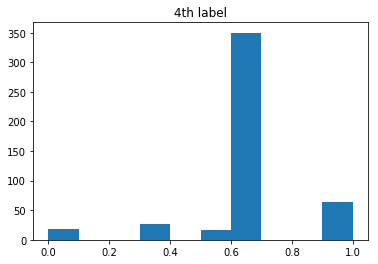

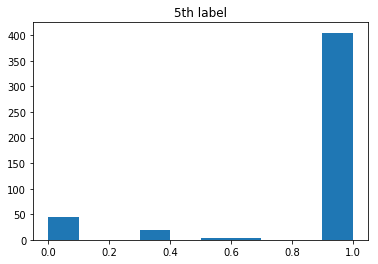

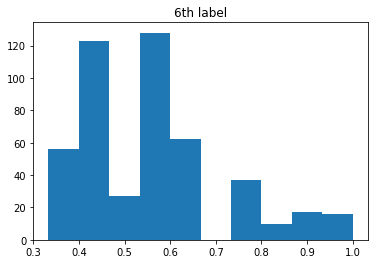

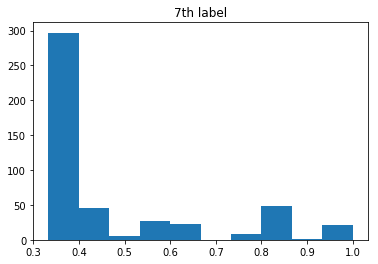

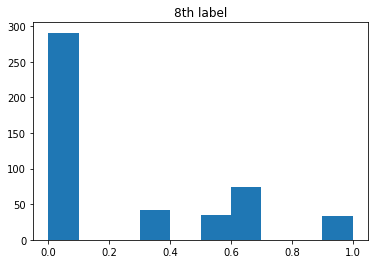

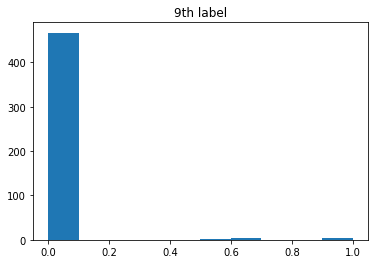

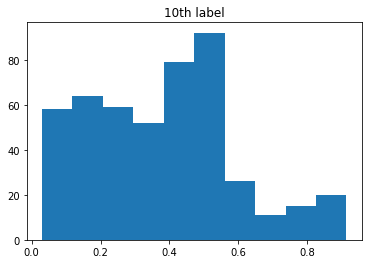

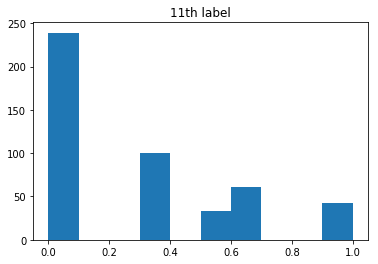

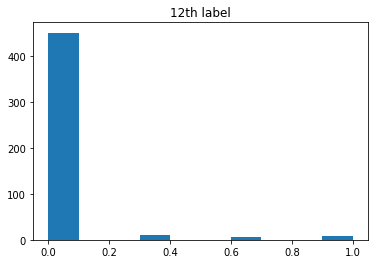

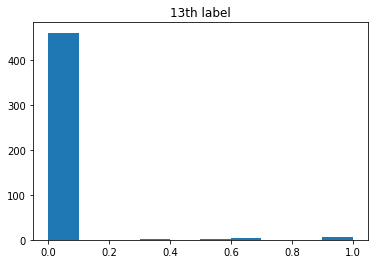

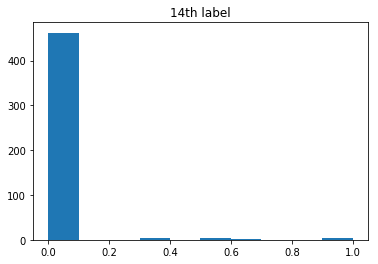

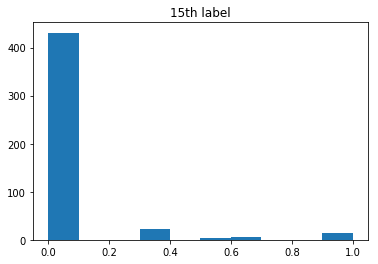

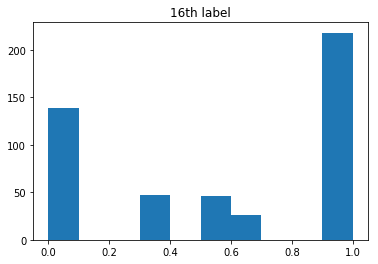

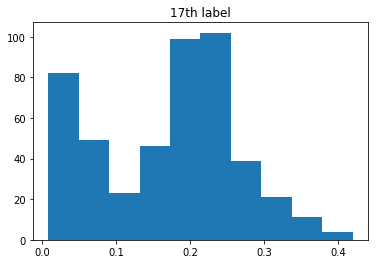

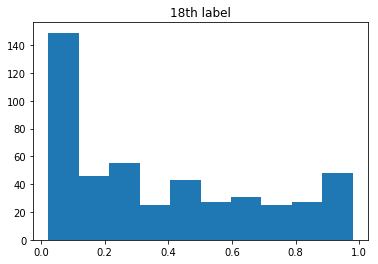

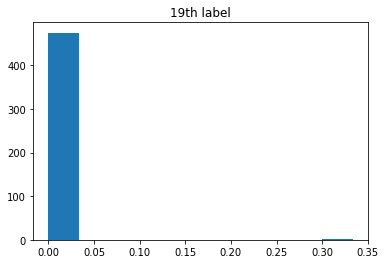

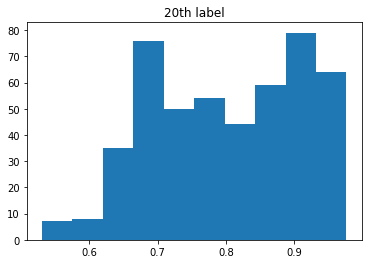

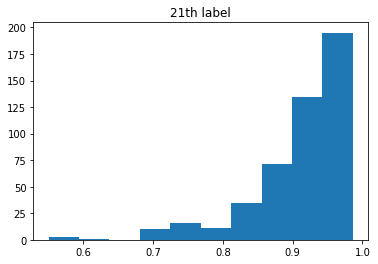

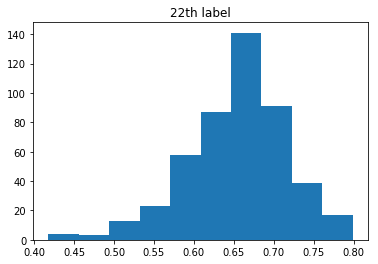

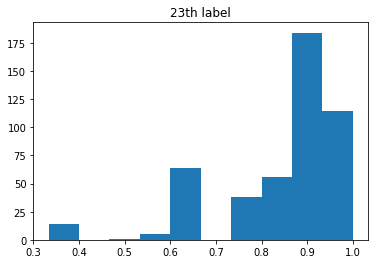

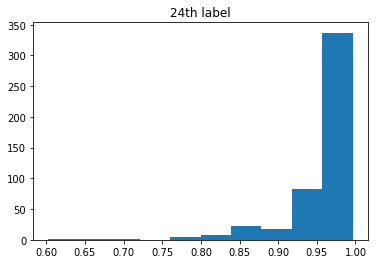

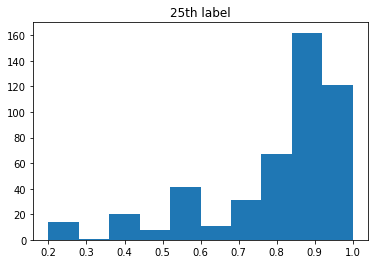

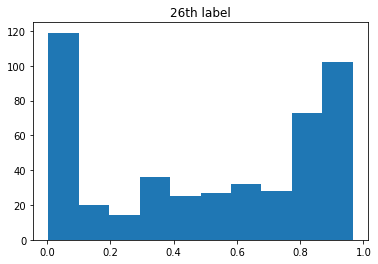

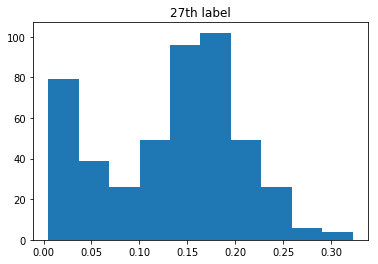

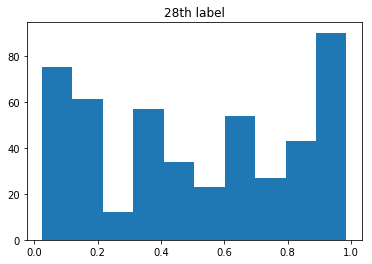

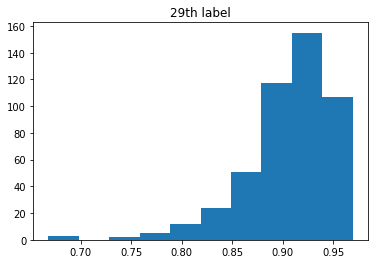

In [ ]:
from matplotlib import pyplot as plt

for i in range(30):
    plt.hist(prediction[:, i])
    plt.title(f'{i}th label')
    plt.show()

In [ ]:
sub_df = pd.read_csv('/kaggle/input/google-quest-challenge/sample_submission.csv')
sub_df.head()

qa_id  question_asker_intent_understanding  question_body_critical  \
0     39                              0.00308                 0.00308   
1     46                              0.00448                 0.00448   
2     70                              0.00673                 0.00673   
3    132                              0.01401                 0.01401   
4    200                              0.02074                 0.02074   

   question_conversational  question_expect_short_answer  \
0                  0.00308                       0.00308   
1                  0.00448                       0.00448   
2                  0.00673                       0.00673   
3                  0.01401                       0.01401   
4                  0.02074                       0.02074   

   question_fact_seeking  question_has_commonly_accepted_answer  \
0                0.00308                                0.00308   
1                0.00448                                0.00448   
2                0.00673                                0.00673   
3                0.01401                                0.01401   
4                0.02074                                0.02074   

   question_interestingness_others  question_interestingness_self  \
0                          0.00308                        0.00308   
1                          0.00448                        0.00448   
2                          0.00673                        0.00673   
3                          0.01401                        0.01401   
4                          0.02074                        0.02074   

   question_multi_intent  ...  question_well_written  answer_helpful  \
0                0.00308  ...                0.00308         0.00308   
1                0.00448  ...                0.00448         0.00448   
2                0.00673  ...                0.00673         0.00673   
3                0.01401  ...                0.01401         0.01401   
4                0.02074  ...                0.02074         0.02074   

   answer_level_of_information  answer_plausible  answer_relevance  \
0                      0.00308           0.00308           0.00308   
1                      0.00448           0.00448           0.00448   
2                      0.00673           0.00673           0.00673   
3                      0.01401           0.01401           0.01401   
4                      0.02074           0.02074           0.02074   

   answer_satisfaction  answer_type_instructions  answer_type_procedure  \
0              0.00308                   0.00308                0.00308   
1              0.00448                   0.00448                0.00448   
2              0.00673                   0.00673                0.00673   
3              0.01401                   0.01401                0.01401   
4              0.02074                   0.02074                0.02074   

   answer_type_reason_explanation  answer_well_written  
0                         0.00308              0.00308  
1                         0.00448              0.00448  
2                         0.00673              0.00673  
3                         0.01401              0.01401  
4                         0.02074              0.02074  

[5 rows x 31 columns]

In [ ]:
sub_df.iloc[:, 1:] = prediction
sub_df.head()

qa_id  question_asker_intent_understanding  question_body_critical  \
0     39                             0.953753                0.734130   
1     46                             0.864954                0.481076   
2     70                             0.905287                0.779890   
3    132                             0.877970                0.442314   
4    200                             0.937422                0.472910   

   question_conversational  question_expect_short_answer  \
0                 0.666667                      0.552790   
1                 0.000000                      0.774251   
2                 0.000000                      0.861916   
3                 0.000000                      0.717528   
4                 0.000000                      0.880901   

   question_fact_seeking  question_has_commonly_accepted_answer  \
0               0.000000                                    0.0   
1               0.666667                                    1.0   
2               0.666667                                    1.0   
3               0.666667                                    1.0   
4               0.666667                                    1.0   

   question_interestingness_others  question_interestingness_self  \
0                         0.888889                       0.833333   
1                         0.500000                       0.333333   
2                         0.555556                       0.333333   
3                         0.444444                       0.333333   
4                         0.777778                       0.777778   

   question_multi_intent  ...  question_well_written  answer_helpful  \
0               0.666667  ...               0.943877        0.825734   
1               0.000000  ...               0.634470        0.946534   
2               0.000000  ...               0.908810        0.946958   
3               0.000000  ...               0.694980        0.962599   
4               0.000000  ...               0.711218        0.836417   

   answer_level_of_information  answer_plausible  answer_relevance  \
0                     0.544132          0.666667          0.911909   
1                     0.653225          0.888889          0.985729   
2                     0.619312          1.000000          0.982961   
3                     0.706732          1.000000          0.990359   
4                     0.603172          0.777778          0.921276   

   answer_satisfaction  answer_type_instructions  answer_type_procedure  \
0             0.533333                  0.025604               0.020181   
1             0.900000                  0.931691               0.124444   
2             0.900000                  0.057012               0.047403   
3             1.000000                  0.837572               0.177240   
4             0.600000                  0.081175               0.061652   

   answer_type_reason_explanation  answer_well_written  
0                        0.845823             0.901144  
1                        0.065411             0.896548  
2                        0.922075             0.929593  
3                        0.707176             0.919323  
4                        0.473391             0.900939  

[5 rows x 31 columns]

In [ ]:
# post process using corr
#sub_df.loc[(sub_df['question_opinion_seeking'] < np.min(optRs[10].coefficients())).values, 'question_fact_seeking'] = 1.
sub_df.loc[(sub_df['question_fact_seeking'] < np.min(optRs[4].coefficients())).values, 'question_opinion_seeking'] = 1.

## avoid scoring error

In [ ]:
pub_qa_id = [39, 46, 70, 132, 200, 245, 257, 267, 284, 292, 296, 312, 322, 327, 334, 340, 357, 374, 375, 387, 391, 395, 444, 482, 483, 513, 542, 579, 589, 625, 641, 683, 725, 727, 728, 740, 748, 765, 811, 830, 851, 856, 885, 905, 929, 938, 939, 962, 1082, 1091, 1101, 1119, 1153, 1226, 1230, 1238, 1247, 1249, 1266, 1282, 1297, 1331, 1359, 1398, 1423, 1477, 1502, 1544, 1567, 1654, 1676, 1700, 1701, 1727, 1764, 1794, 1795, 1807, 1812, 1816, 1833, 1847, 1868, 1877, 1885, 1934, 1959, 1983, 1990, 2005, 2018, 2027, 2042, 2066, 2070, 2075, 2094, 2128, 2163, 2180, 2203, 2230, 2244, 2257, 2277, 2278, 2286, 2303, 2335, 2374, 2387, 2395, 2455, 2465, 2474, 2487, 2493, 2534, 2569, 2573, 2580, 2592, 2607, 2621, 2655, 2666, 2669, 2670, 2676, 2691, 2748, 2763, 2774, 2789, 2793, 2795, 2797, 2806, 2844, 2868, 2895, 2912, 2922, 2931, 2968, 3034, 3062, 3087, 3107, 3173, 3207, 3229, 3290, 3336, 3378, 3399, 3437, 3461, 3463, 3502, 3504, 3524, 3526, 3527, 3532, 3543, 3544, 3560, 3592, 3671, 3682, 3696, 3720, 3787, 3854, 3871, 3876, 3881, 3901, 3941, 3943, 3949, 3961, 3962, 3967, 4006, 4039, 4057, 4070, 4099, 4139, 4157, 4160, 4176, 4182, 4183, 4211, 4213, 4250, 4263, 4269, 4281, 4284, 4285, 4286, 4346, 4387, 4388, 4401, 4416, 4441, 4497, 4546, 4547, 4564, 4569, 4575, 4598, 4607, 4663, 4679, 4743, 4751, 4778, 4792, 4835, 4881, 4901, 4954, 4973, 5001, 5003, 5019, 5035, 5050, 5057, 5076, 5091, 5095, 5141, 5152, 5253, 5367, 5373, 5403, 5417, 5422, 5499, 5503, 5530, 5541, 5542, 5660, 5663, 5697, 5753, 5783, 5790, 5835, 5847, 5862, 5878, 5891, 5904, 5907, 5914, 5936, 5947, 5958, 5972, 5979, 5998, 6016, 6042, 6058, 6079, 6087, 6111, 6126, 6132, 6159, 6204, 6212, 6226, 6258, 6271, 6280, 6285, 6301, 6319, 6325, 6331, 6332, 6336, 6346, 6378, 6379, 6420, 6445, 6481, 6494, 6495, 6502, 6560, 6580, 6583, 6621, 6643, 6646, 6688, 6694, 6715, 6723, 6737, 6744, 6745, 6766, 6770, 6774, 6821, 6832, 6838, 6856, 6888, 6889, 6955, 6957, 6964, 6988, 6994, 7012, 7018, 7036, 7064, 7072, 7114, 7116, 7123, 7150, 7165, 7176, 7194, 7201, 7216, 7247, 7254, 7272, 7278, 7281, 7293, 7302, 7326, 7404, 7410, 7438, 7477, 7481, 7485, 7519, 7520, 7525, 7531, 7544, 7546, 7589, 7595, 7614, 7640, 7654, 7672, 7711, 7727, 7739, 7758, 7766, 7815, 7838, 7852, 7869, 7878, 7899, 7935, 7939, 7970, 8021, 8032, 8045, 8070, 8089, 8115, 8143, 8146, 8191, 8197, 8206, 8212, 8242, 8245, 8250, 8258, 8271, 8273, 8339, 8350, 8355, 8376, 8395, 8412, 8427, 8437, 8464, 8496, 8516, 8517, 8551, 8564, 8591, 8621, 8626, 8629, 8672, 8684, 8685, 8690, 8738, 8755, 8756, 8760, 8771, 8773, 8778, 8823, 8834, 8842, 8846, 8875, 8916, 8921, 8932, 8934, 8938, 8973, 8987, 9001, 9006, 9018, 9033, 9065, 9140, 9141, 9174, 9213, 9225, 9228, 9237, 9240, 9256, 9259, 9263, 9298, 9324, 9350, 9391, 9400, 9439, 9454, 9476, 9478, 9497, 9545, 9567, 9569, 9590, 9597, 9623, 9640]
# pub_qa_id = [70, 132, 200, 245, 257, 267, 284, 292, 296, 312, 322, 327, 334, 340, 357, 374, 375, 387, 391, 395, 444, 482, 483, 513, 542, 579, 589, 625, 641, 683, 725, 727, 728, 740, 748, 765, 811, 830, 851, 856, 885, 905, 929, 938, 939, 962, 1082, 1091, 1101, 1119, 1153, 1226, 1230, 1238, 1247, 1249, 1266, 1282, 1297, 1331, 1359, 1398, 1423, 1477, 1502, 1544, 1567, 1654, 1676, 1700, 1701, 1727, 1764, 1794, 1795, 1807, 1812, 1816, 1833, 1847, 1868, 1877, 1885, 1934, 1959, 1983, 1990, 2005, 2018, 2027, 2042, 2066, 2070, 2075, 2094, 2128, 2163, 2180, 2203, 2230, 2244, 2257, 2277, 2278, 2286, 2303, 2335, 2374, 2387, 2395, 2455, 2465, 2474, 2487, 2493, 2534, 2569, 2573, 2580, 2592, 2607, 2621, 2655, 2666, 2669, 2670, 2676, 2691, 2748, 2763, 2774, 2789, 2793, 2795, 2797, 2806, 2844, 2868, 2895, 2912, 2922, 2931, 2968, 3034, 3062, 3087, 3107, 3173, 3207, 3229, 3290, 3336, 3378, 3399, 3437, 3461, 3463, 3502, 3504, 3524, 3526, 3527, 3532, 3543, 3544, 3560, 3592, 3671, 3682, 3696, 3720, 3787, 3854, 3871, 3876, 3881, 3901, 3941, 3943, 3949, 3961, 3962, 3967, 4006, 4039, 4057, 4070, 4099, 4139, 4157, 4160, 4176, 4182, 4183, 4211, 4213, 4250, 4263, 4269, 4281, 4284, 4285, 4286, 4346, 4387, 4388, 4401, 4416, 4441, 4497, 4546, 4547, 4564, 4569, 4575, 4598, 4607, 4663, 4679, 4743, 4751, 4778, 4792, 4835, 4881, 4901, 4954, 4973, 5001, 5003, 5019, 5035, 5050, 5057, 5076, 5091, 5095, 5141, 5152, 5253, 5367, 5373, 5403, 5417, 5422, 5499, 5503, 5530, 5541, 5542, 5660, 5663, 5697, 5753, 5783, 5790, 5835, 5847, 5862, 5878, 5891, 5904, 5907, 5914, 5936, 5947, 5958, 5972, 5979, 5998, 6016, 6042, 6058, 6079, 6087, 6111, 6126, 6132, 6159, 6204, 6212, 6226, 6258, 6271, 6280, 6285, 6301, 6319, 6325, 6331, 6332, 6336, 6346, 6378, 6379, 6420, 6445, 6481, 6494, 6495, 6502, 6560, 6580, 6583, 6621, 6643, 6646, 6688, 6694, 6715, 6723, 6737, 6744, 6745, 6766, 6770, 6774, 6821, 6832, 6838, 6856, 6888, 6889, 6955, 6957, 6964, 6988, 6994, 7012, 7018, 7036, 7064, 7072, 7114, 7116, 7123, 7150, 7165, 7176, 7194, 7201, 7216, 7247, 7254, 7272, 7278, 7281, 7293, 7302, 7326, 7404, 7410, 7438, 7477, 7481, 7485, 7519, 7520, 7525, 7531, 7544, 7546, 7589, 7595, 7614, 7640, 7654, 7672, 7711, 7727, 7739, 7758, 7766, 7815, 7838, 7852, 7869, 7878, 7899, 7935, 7939, 7970, 8021, 8032, 8045, 8070, 8089, 8115, 8143, 8146, 8191, 8197, 8206, 8212, 8242, 8245, 8250, 8258, 8271, 8273, 8339, 8350, 8355, 8376, 8395, 8412, 8427, 8437, 8464, 8496, 8516, 8517, 8551, 8564, 8591, 8621, 8626, 8629, 8672, 8684, 8685, 8690, 8738, 8755, 8756, 8760, 8771, 8773, 8778, 8823, 8834, 8842, 8846, 8875, 8916, 8921, 8932, 8934, 8938, 8973, 8987, 9001, 9006, 9018, 9033, 9065, 9140, 9141, 9174, 9213, 9225, 9228, 9237, 9240, 9256, 9259, 9263, 9298, 9324, 9350, 9391, 9400, 9439, 9454, 9476, 9478, 9497, 9545, 9567, 9569, 9590, 9597, 9623, 9640]

In [ ]:
sub_df_cols = sub_df.columns[1:]
sub_df_cols

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [ ]:
for i in range(30):
    sub_df_col = sub_df_cols[i]

    pub_y_pred = raw_prediction[sub_df.qa_id.isin(pub_qa_id).values, i]
    pub_y_res = sub_df.loc[sub_df.qa_id.isin(pub_qa_id).values, sub_df_col].values

    pub_y_pred_argmax = np.argmax(pub_y_pred)
    pub_y_pred_argmin = np.argmin(pub_y_pred)

    if len(np.unique(pub_y_res)) == 1:
        #if np.unique(pub_y_res)[0] == pub_y_pred[pub_y_pred_argmax]:
        #    if np.unique(pub_y_res)[0] == pub_y_pred[pub_y_pred_argmin]:
        #        if np.unique(pub_y_res)[0] > 0.5:
        #            pub_y_res[pub_y_pred_argmin] = 0
        #        else:
        #            pub_y_res[pub_y_pred_argmax] = 1
        #    else:
        #        pub_y_res[pub_y_pred_argmin] = np.min(pub_y_pred)
        #else:
        #    pub_y_res[pub_y_pred_argmax] = np.max(pub_y_pred)
        pub_y_res = pub_y_pred
    sub_df.loc[sub_df.qa_id.isin(pub_qa_id).values, sub_df_col] = pub_y_res


    pri_y_pred = raw_prediction[~(sub_df.qa_id.isin(pub_qa_id).values), i]

    # only for sub
    if len(pri_y_pred) == 0:
        continue
    pri_y_res = sub_df.loc[~(sub_df.qa_id.isin(pub_qa_id).values), sub_df_col].values

    pri_y_pred_argmax = np.argmax(pri_y_pred)
    pri_y_pred_argmin = np.argmin(pri_y_pred)

    if len(np.unique(pri_y_res)) == 1:
        #if np.unique(pri_y_res)[0] == pri_y_pred[pri_y_pred_argmax]:
        #    if np.unique(pri_y_res)[0] == pri_y_pred[pri_y_pred_argmin]:
        #        if np.unique(pri_y_res)[0] > 0.5:
        #            pri_y_res[pri_y_pred_argmin] = 0
        #        else:
        #            pri_y_res[pri_y_pred_argmax] = 1
        #    else:
        #        pri_y_res[pri_y_pred_argmin] = np.min(pri_y_pred)
        #else:
        #    pri_y_res[pri_y_pred_argmax] = np.max(pri_y_pred)
        pri_y_res = pri_y_pred

    sub_df.loc[~(sub_df.qa_id.isin(pub_qa_id).values), sub_df_col] = pri_y_res

In [ ]:
n = test_df['url'].apply(lambda x:('english.stackexchange.com' in x)).tolist()
# n = (test_df['host'].isin(['english.stackexchange.com', 'ell.stackexchange.com']).values & (test_df['category'] == 'CULTURE').values).tolist()
spelling=[]
for x in n:
    if x:
        spelling.append(0.5)
    else:
        spelling.append(0.)

In [ ]:
sub_df['question_type_spelling'] = spelling

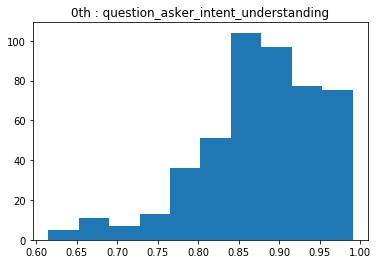

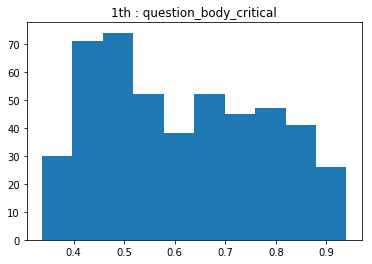

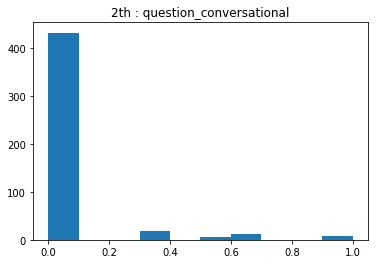

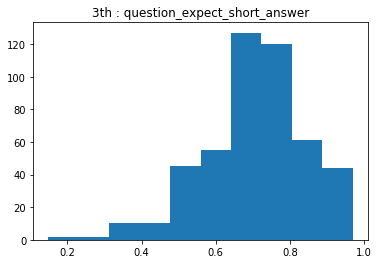

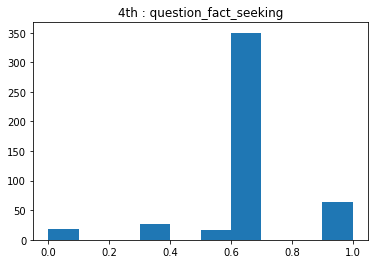

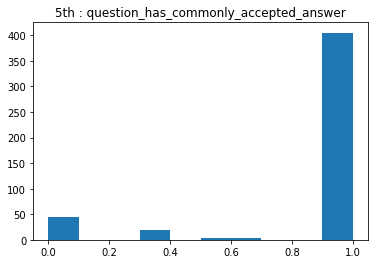

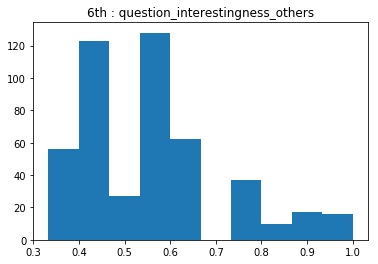

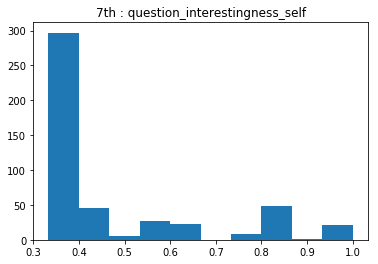

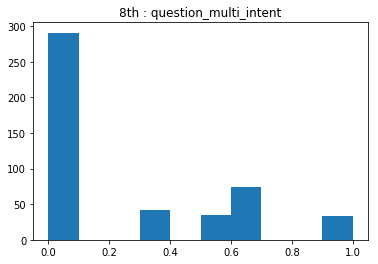

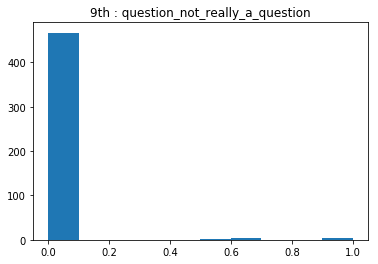

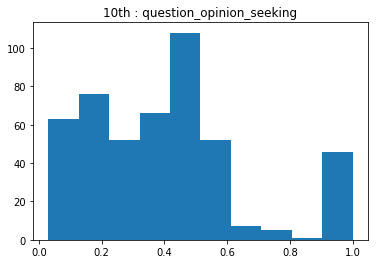

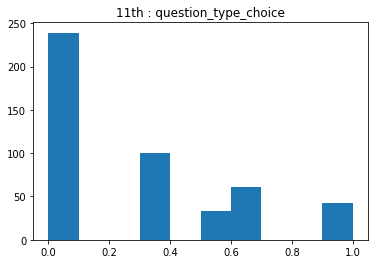

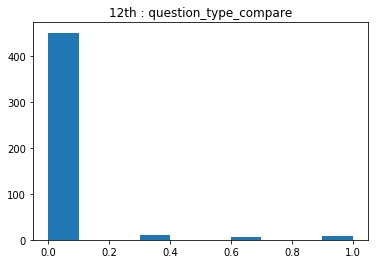

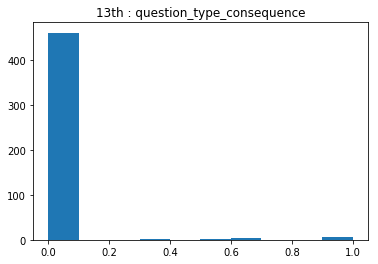

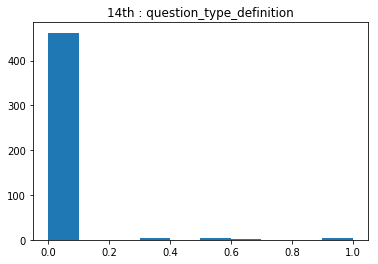

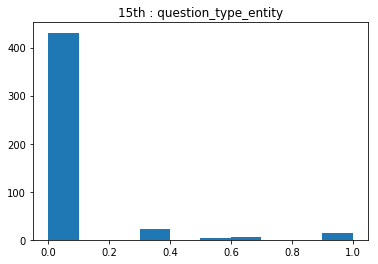

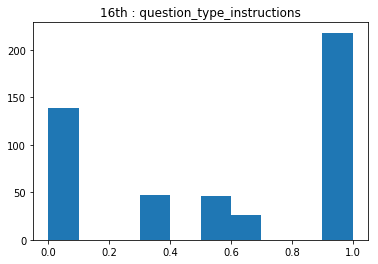

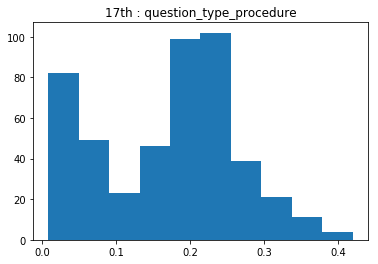

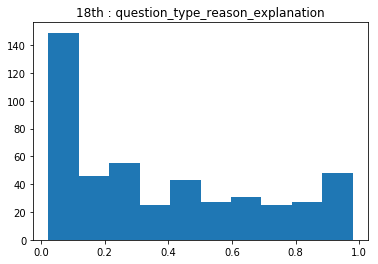

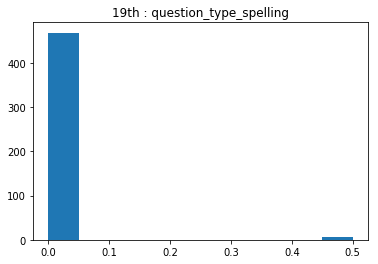

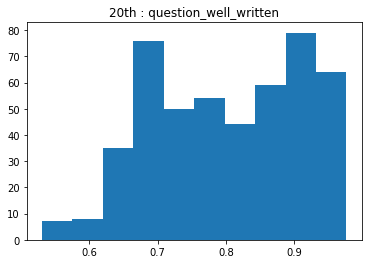

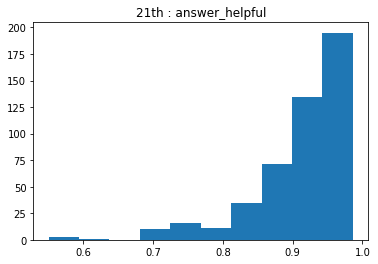

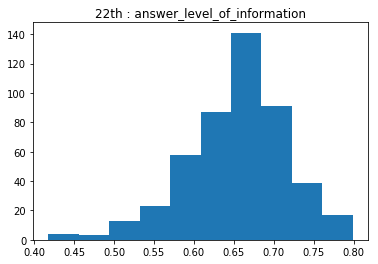

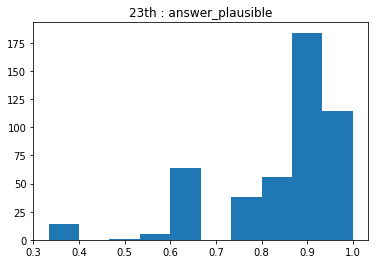

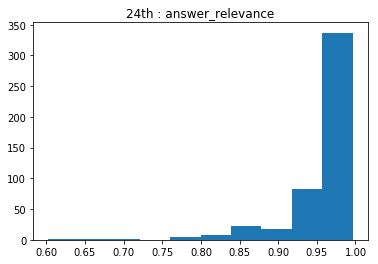

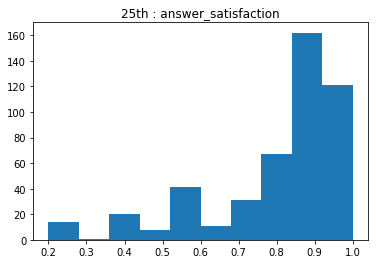

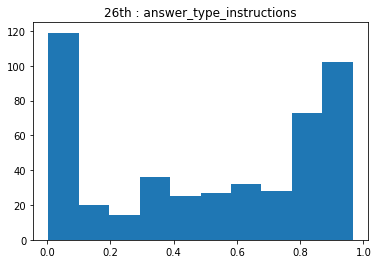

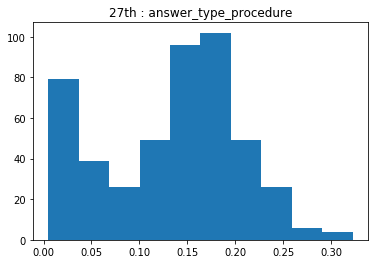

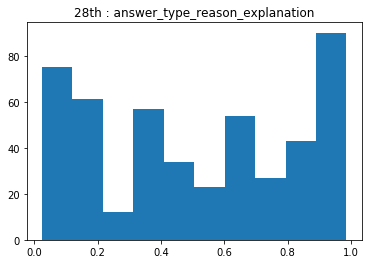

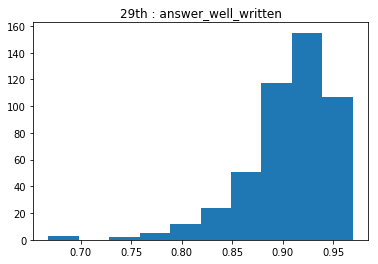

In [ ]:
for i in range(30):
    plt.hist(sub_df.iloc[:, i+1])
    plt.title(f'{i}th : {sub_df.columns[i+1]}')
    plt.show()

In [ ]:
sub_df.to_csv("submission.csv", index=False)